### ay data need to be in the NetCDF before the debiasing the ACS chl
#### Note: this is based on the NASA HPLC xls file for AMT29

In [1]:
# this is to make the Jupyter notebook as wide as the screen (on the Mac at least)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%config InlineBackend.figure_format ='retina'


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy import signal as sg
from datetime import datetime as dt

In [3]:
%matplotlib notebook

In [4]:
def prcrng(x):
    return (np.nanpercentile(x,84) - np.nanpercentile(x,16))/2.

In [5]:
DIN_hplc = "/data/datasets/cruise_data/active/AMT24/HPLC/"
DIN_acs = "/users/rsg/tjor/scratch_network/AMT_underway/AMT24/Processed/Uway/Step3/"

In [6]:
fn_hplc =  "AMT_24_PigmentsDen2.xlsx"
#fn_meta = "Filtering-Log-HPLC-AMT25_reformat.xlsx"
fn_optics = "amt24_final.nc"

In [7]:
print(DIN_hplc + fn_hplc)

df_hplc = pd.read_excel(DIN_hplc + fn_hplc, sheet_name = "BODC_submission_template", header = 16, engine = 'openpyxl', nrows=130)
df_hplc.keys()

#list(df_hplc['Sample name'])
df_hplc.rename(columns={'Sample name': 'Label'}, inplace = True)

print(df_hplc.keys())
print(df_hplc['Label'])
#acs_filtered2 = acs_filtered


# df_hplc

/data/datasets/cruise_data/active/AMT24/HPLC/AMT_24_PigmentsDen2.xlsx
Index(['Label', 'Sample Collector', 'Cruise Name', 'CTD number', 'GMT',
       'Volume filtered (L)', 'Name of Water Body',
       'collected with positive pressure or vacuum', 'Depth (meters)',
       'Filter storage before analysis', 'Filter type', 'Filter diameter (mm)',
       '[TChl a]', '[TChl b]', '[TChl c]', '[Caro]', '[Allo]', '[But fuco]',
       '[Diad]', '[Diato]', '[Fuco]', '[Hex fuco]', '[Perid]', '[Zea]',
       '[Chl a]', '[DVChl a]', '[Chlide a]', '[Chl b] + [DVChl b]', '[Chl c1]',
       '[Chl c2]', '[Chl c3]', '[βε-Car]', '[ββ-Car]', '[Lut]', '[Neo]',
       '[Viola]', '[Pras]', '[Anth]', '[Asta]', 'blank intentionally',
       '[TChl]', '[PPC]', '[PSC]', '[PSP]', '[TAcc]', '[TPig]',
       '[TAcc]/[Tchla]', '[PPC]/[Tpig]', '[PSP]/[TPig]', '[TChl a]/[TPig]'],
      dtype='object')
0     AMT24_ctd008_0m
1     AMT24_ctd010_0m
2     AMT24_ctd012_0m
3     AMT24_ctd013_0m
4     AMT24_ctd015_0m
5     AMT

In [8]:
# NO HPLC META DATA IN AMT24


#print(DIN_hplc + fn_meta)
#df_meta = pd.read_excel(DIN_hplc + fn_meta, header = 0)
#df_meta.keys()
#list(df_meta['NAME'])


#label = []; # match sample/name ID between meta and hplc file
#for i in range(len(df_meta)):
 #   old_string = (str(df_meta['NAME'][i]))
  #  new_string = old_string.replace(":", "" )
   # label.append(new_string)

#df_meta['Label'] = label


#print(df_meta['Label'])

In [9]:
# merge two tables to extract info from df_meta

# NO HPLC META DATA IN AMT24

#print(df_hplc['Label'])
#print(df_meta['Label'])

#df_hplc = pd.merge(df_hplc, df_meta, on=['Label'])

#sorted(df_hplc.keys())

In [10]:
# convert PML pigment names to NASA pigment names for submission
#                            PML  :  NASA


pml2nasa = {            
                          "[Allo]":"Allo",
                          "[Asta]": "Asta",
                          "[Anth]": "PML_only_Anth",
                      "[But fuco]":"But-fuco",
                          "[Caro]":"Alpha-beta-Car", # !!!! TO CHECK !!!
                         "[Chl a]":'Chl_a',
             "[Chl b] + [DVChl b]":"PML_only_Chl_b_DVChl_b",
                        '[Chl c1]':'Chl_c1',
                        '[Chl c2]':'Chl_c2',
                        '[Chl-c3]':'Chl_c3',
                      "[Chlide a]":"Chlide_a",
                          "[Diad]":"Diadino",
                         "[Diato]":"Diato",
                       "[DVChl a]":"DV_Chl_a",
                          "[Fuco]":"Fuco",
                      "[Hex fuco]":"Hex-fuco",
                           "[Lut]":"Lut",
                        # '[MgDVP]':'Mg_DVP', - present in AMT 26 and AMT 25, but not AMT 24
                           '[Neo]':'Neo',
                           "[PPC]":"PPC",
                           "[PSC]":"PSC",
                           "[PSP]":"PSP",
                         "[Perid]":"Perid",
                          "[Pras]":"Pras",
                           "[Zea]":"Zea",
                          "[TAcc]":"Tacc",
                          "[TChl]":"TChl",
                        "[TChl a]":"Tot_Chl_a",
                        "[TChl b]":"Tot_Chl_b",
                        "[TChl c]":"Tot_Chl_c",
                          '[TPig]': "Tpg",
                         '[Viola]':'Viola',
                        '[ββ-Car]':"beta-beta-Car",
                        '[βε-Car]':"beta-epi-Car",                  
            
           }
#                     "a-carotene":"Alpha-beta-Car", # these two successive pigments need to be merged (see below)
#                     "b-carotene":"Alpha-beta-Car"}

# rename DHI columns with NASA names
df_hplc = df_hplc.rename(columns = pml2nasa)

# create merged pigments
# "Alpha-beta-Car", 
#df_hplc["Alpha-beta-Car"] = df_hplc["a-carotene"] + df_hplc["b-carotene"] - ALREADY IN MERGED FORMAT
#df_hplc = df_hplc.drop(columns=["a-carotene", "b-carotene"]) - 
           
# "Chl c1c2"
#df_hplc["Chl_c1c2"] = df_hplc["Chl_c2"] + df_hplc["Chl_c1"]  +df_hplc["Mg_DVP"]- cannot defined for AMT24 as Mg_DVP not present.

# "Tot_Chl_a" = DV_Chl_a + MV_Chl_a + Chlide_a (+ Chl_a allomers + Chl_a epimers)   - ALREADY IN MERGED FORMAT
#df_hplc["Tot_Chl_a"] = df_hplc["DV_Chl_a"] + df_hplc["MV_Chl_a"] + df_hplc["Chlide_a"]

# "Tot_Chl_c" = Tot_Chl_a + Tot_Chl_b + Tot_Chl_c - ALREADY IN MERGED FORMAT
#df_hplc["Tot_Chl_c"] = df_hplc["Chl_c3"] + df_hplc["Chl_c1c2"]

# "Tchl" = Tot_Chl_a + Tot_Chl_b + Tot_Chl_c - ALREADY IN MERGED FORMAT
#df_hplc["Tchl"] = df_hplc["Tot_Chl_a"] + df_hplc["Tot_Chl_b"] + df_hplc["Tot_Chl_c"]

# "PPC" (photoprotective carotenoids) = allo + diadino + diato + zea + alpha-beta-car)
#f_hplc["PPC"] = df_hplc["Allo"] + df_hplc["Diadino"] + df_hplc["Diato"] + df_hplc["Zea"] + df_hplc["Alpha-beta-Car"]

# "PSC" (photosynthetic carotenoids) = but-fuco + fuco + hex-fuco + perid
#df_hplc["PSC"] = df_hplc["But-fuco"] + df_hplc["Fuco"] + df_hplc["Hex-fuco"] + df_hplc["Perid"] 

# "PSP" (phosynthetic pigments) = PSC + TChl
#df_hplc["PSP"] = df_hplc["PSC"] + df_hplc["Tchl"] 

# "Tcar" (total carotenoids) = PPC + PSC
df_hplc["Tcar"] = df_hplc["PPC"] + df_hplc["PSC"] 

# "Tacc" (total accessory pigments) = PPC + PSC + Tot_Chl_b + Tot_Chl_c  - ALREADY IN MERGED FORMAT
#df_hplc["Tacc"] = df_hplc["PPC"] + df_hplc["PSC"] + df_hplc["Tot_Chl_b"] + df_hplc["Tot_Chl_c"] 

# "Tpg" (total pigments) = TAcc + Tot_Chl_a - ALREADY IN MERGED FORMAT
#df_hplc["Tpg"] = df_hplc["Tacc"] + df_hplc["Tot_Chl_a"] 

# "DP" (total diagnostic pigments) = PSC + allo + zea + Tot_Chl_b
df_hplc["DP"] = df_hplc["PSC"] + df_hplc["Allo"] + df_hplc["Zea"] + df_hplc["Tot_Chl_b"]


# new dictionary with additional pigments
derived_pigs = {#"Alpha-beta-Car":"Alpha-beta-Car",
                "Chl_c1c2":"Chl_c1c2",
               # "Tot_Chl_a":"Tot_Chl_a", - already added
               # "Tot_Chl_c":"Tot_Chl_c",
                #"Tchl":"Tchl",
                #"PPC":"PPC",
                #"PSC":"PSC",
                #"PSP":"PSP",
                "Tcar":"Tcar",
                "DP":"DP"      }


# drop pigment ratios 

df_hplc.keys()



Index(['Label', 'Sample Collector', 'Cruise Name', 'CTD number', 'GMT',
       'Volume filtered (L)', 'Name of Water Body',
       'collected with positive pressure or vacuum', 'Depth (meters)',
       'Filter storage before analysis', 'Filter type', 'Filter diameter (mm)',
       'Tot_Chl_a', 'Tot_Chl_b', 'Tot_Chl_c', 'Alpha-beta-Car', 'Allo',
       'But-fuco', 'Diadino', 'Diato', 'Fuco', 'Hex-fuco', 'Perid', 'Zea',
       'Chl_a', 'DV_Chl_a', 'Chlide_a', 'PML_only_Chl_b_DVChl_b', 'Chl_c1',
       'Chl_c2', '[Chl c3]', 'beta-epi-Car', 'beta-beta-Car', 'Lut', 'Neo',
       'Viola', 'Pras', 'PML_only_Anth', 'Asta', 'blank intentionally', 'TChl',
       'PPC', 'PSC', 'PSP', 'Tacc', 'Tpg', '[TAcc]/[Tchla]', '[PPC]/[Tpig]',
       '[PSP]/[TPig]', '[TChl a]/[TPig]', 'Tcar', 'DP'],
      dtype='object')

In [11]:
# drop pigment ratios 
#df_hplc = df_hplc.drop('void1') # redumdant
#df_hplc = df_hplc.drop('[PPC]/[Tpig]') # redumdant
#df_hplc = df_hplc.drop('[PSP]/[TPig]') # redumdant
#df_hplc = df_hplc.drop('[TChl a]/[TPig]') # redumdant

#df_hplc['[TAcc]/[Tchla]'] =[]

In [12]:
# merge dictonaries with names of all pigments
all_pigs = dict(pml2nasa, **derived_pigs)

print(all_pigs)

{'[Allo]': 'Allo', '[Asta]': 'Asta', '[Anth]': 'PML_only_Anth', '[But fuco]': 'But-fuco', '[Caro]': 'Alpha-beta-Car', '[Chl a]': 'Chl_a', '[Chl b] + [DVChl b]': 'PML_only_Chl_b_DVChl_b', '[Chl c1]': 'Chl_c1', '[Chl c2]': 'Chl_c2', '[Chl-c3]': 'Chl_c3', '[Chlide a]': 'Chlide_a', '[Diad]': 'Diadino', '[Diato]': 'Diato', '[DVChl a]': 'DV_Chl_a', '[Fuco]': 'Fuco', '[Hex fuco]': 'Hex-fuco', '[Lut]': 'Lut', '[Neo]': 'Neo', '[PPC]': 'PPC', '[PSC]': 'PSC', '[PSP]': 'PSP', '[Perid]': 'Perid', '[Pras]': 'Pras', '[Zea]': 'Zea', '[TAcc]': 'Tacc', '[TChl]': 'TChl', '[TChl a]': 'Tot_Chl_a', '[TChl b]': 'Tot_Chl_b', '[TChl c]': 'Tot_Chl_c', '[TPig]': 'Tpg', '[Viola]': 'Viola', '[ββ-Car]': 'beta-beta-Car', '[βε-Car]': 'beta-epi-Car', 'Chl_c1c2': 'Chl_c1c2', 'Tcar': 'Tcar', 'DP': 'DP'}


In [13]:
# find matching keys and merge them into a single one
for key in df_hplc.keys():
    if "_x" in key:
        print(key)
        if ~(np.all(df_hplc[key] == df_hplc[key[:-1]+"y"])):
            print([key, " not matching"])
        else:
            # drop *_x key
            print(["droppping " + key ])
            df_hplc = df_hplc.drop(columns = [key])
            # rename *_y key
            print(["renaming " + key ])
            df_hplc = df_hplc.rename(columns = {key[:-1]+"y" : key[:-2]})
            

In [14]:
# convert date (numpy.datetime64) and time (datetime.time) to a single datetime object
from datetime import datetime as dt

#print((df_hplc['GMT']))
print((df_hplc['GMT'][0]))


time = [dt.strptime(str((df_hplc['GMT'])[i]),"%Y-%m-%d %H:%M:%S") for i in range(len(df_hplc))]


df_hplc['time'] = time
# drop Date and Time
df_hplc = df_hplc.drop(columns = ["GMT"])
                       
df_hplc = df_hplc.sort_values(by = ['time'])
df_hplc = df_hplc.reset_index(drop = True)


2014-09-29 13:15:00


In [15]:
# clean up lat
#tmpla = df_hplc['Lat'].values
#for i,la in enumerate(tmpla):
   # if (type(la) != float) & (type(la) != int):
#         print(type(la))
#         print(i, "    ", la)
        # assume the string is similar to "31°31.784'W"
        
        # replace "º" by "°"
     #   la = la.replace("º", "°")
        
    #    degrees = float(la.split("°")[0]) 
     #   minutes = float(la.split("°")[-1].split("'")[0])
    #    NoS = la.split("°")[-1].split("'")[-1]
     #   sign = -1
      #  if (NoS.upper() == "N"):
          #  sign = 1
       # df_hplc.at[i, 'Lat'] = sign*(degrees + minutes/60.)

# clean up lon
#tmplo = df_hplc['Lon'].values
#for i,lo in enumerate(tmplo):
 #   if (type(lo) != float) & (type(lo) != int):
#         print(type(lo))
#         print(i, "    ", lo)
        # assume the string is similar to "31°31.784'"
        
        # replace "º" by "°"
  #      lo = lo.replace("º", "°")
        
   #     degrees = float(lo.split("°")[0]) 
    #    minutes = float(lo.split("°")[-1].split("'")[0])
     #   EoW = lo.split("°")[-1].split("'")[-1]
      #  sign = -1
      #  if (EoW.upper() == "E"):
       #     sign = 1
       # df_hplc.at[i, 'Lon'] = sign*(degrees + minutes/60.)
        
##df_hplc.rename(columns={'LAT': 'Lat'}, inplace = True)
#df_hplc.rename(columns={'LON': 'Lon'}, inplace = True)
#print(df_hplc.keys())


In [16]:
df_hplc               



,Label,Sample Collector,Cruise Name,CTD number,Volume filtered (L),Name of Water Body,collected with positive pressure or vacuum,Depth (meters),Filter storage before analysis,Filter type,...,PSP,Tacc,Tpg,[TAcc]/[Tchla],[PPC]/[Tpig],[PSP]/[TPig],[TChl a]/[TPig],Tcar,DP,time
0,AMT24_ctd008_0m,Gavin Tilstone,AMT24,8,3.70,Atlantic Ocean,V,2,minus 80oC,GF/F,...,0.136009,0.114213,0.191621,1.475448,0.290222,0.709778,0.403967,0.089127,0.082079,2014-09-29 13:15:00
1,AMT24_ctd010_0m,Gavin Tilstone,AMT24,10,3.10,Atlantic Ocean,V,2,minus 80oC,GF/F,...,0.163421,0.155202,0.241686,1.794569,0.323827,0.676173,0.357837,0.112034,0.102072,2014-09-30 13:46:00
2,AMT24_ctd012_0m,Gavin Tilstone,AMT24,12,4.00,Atlantic Ocean,V,2,minus 80oC,GF/F,...,0.140359,0.132637,0.221434,1.493720,0.366138,0.633862,0.401007,0.111256,0.101136,2014-10-01 13:45:00
3,AMT24_ctd013_0m,Gavin Tilstone,AMT24,13,2.21,Atlantic Ocean,V,2,minus 80oC,GF/F,...,0.237911,0.209746,0.360846,1.388130,0.340686,0.659314,0.418738,0.169492,0.158630,2014-10-02 13:42:00
4,AMT24_ctd015_0m,Gavin Tilstone,AMT24,15,4.00,Atlantic Ocean,V,2,minus 80oC,GF/F,...,0.099556,0.088370,0.143246,1.610359,0.304999,0.695001,0.383089,0.069380,0.066720,2014-10-03 13:46:00
5,AMT24_ctd019_0m,Gavin Tilstone,AMT24,19,4.00,Atlantic Ocean,V,2,minus 80oC,GF/F,...,0.070175,0.067190,0.104137,1.818520,0.326130,0.673870,0.354796,0.052358,0.048770,2014-10-05 14:49:00
6,AMT24_ctd024_0m,Gavin Tilstone,AMT24,24,2.50,Atlantic Ocean,V,2,minus 80oC,GF/F,...,0.124095,0.113778,0.186842,1.557236,0.335826,0.664174,0.391047,0.090065,0.086280,2014-10-07 14:53:00
7,AMT24_ctd026_0m,Gavin Tilstone,AMT24,26,4.00,Atlantic Ocean,V,2,minus 80oC,GF/F,...,0.122079,0.112494,0.193112,1.395401,0.367830,0.632170,0.417467,0.091179,0.084776,2014-10-08 14:49:00
8,AMT24_ctd028_0m,Gavin Tilstone,AMT24,28,4.00,Atlantic Ocean,V,2,minus 80oC,GF/F,...,0.194134,0.189844,0.320355,1.454614,0.394003,0.605997,0.407396,0.157543,0.155872,2014-10-09 14:50:00
9,AMT24_ctd030_0m,Gavin Tilstone,AMT24,30,3.98,Atlantic Ocean,V,2,minus 80oC,GF/F,...,0.202953,0.199499,0.336783,1.453177,0.397378,0.602622,0.407635,0.163197,0.156102,2014-10-10 14:49:00


In [17]:
# remove 1 micron filter data  - not needed for AMT26

#index_keep = [];
#for i in range(len(df_hplc_surf)):
#    if df_hplc_surf["Label"].iloc[i][-6:-1] != 'Micro':
 #       index_keep.append(i) 

#df_hplc_surf = df_hplc_surf.iloc[index_keep]
                        
              
#df_hplc_surf = df_hplc[isurf]
#df_hplc_surf = df_hplc_surf.set_index("time")
#df_hplc_surf

In [18]:
index_keep = [];

for i in range(len(df_hplc)):
    print(df_hplc["Depth (meters)"].iloc[i])
    if  df_hplc["Depth (meters)"].iloc[i] <= 10:
        print(i)
        df_hplc["Depth (meters)"].iloc[i] = 7
        index_keep.append(i) 

df_hplc_surf = df_hplc.iloc[index_keep]

df_hplc_surf = df_hplc_surf.set_index("time") # set index for time





2
0
2
1
2
2
2
3
2
4
2
5
2
6
2
7
2
8
2
9
2
10
2
11
2
12
2
13
2
14
2
15
2
16
2
17
2
18
2
19
2
20
2
21
2
22
2
23
2
24
2
25


/tmp/ipykernel_113392/3132872953.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hplc["Depth (meters)"].iloc[i] = 7


In [19]:
df_hplc_surf


,Label,Sample Collector,Cruise Name,CTD number,Volume filtered (L),Name of Water Body,collected with positive pressure or vacuum,Depth (meters),Filter storage before analysis,Filter type,...,PSC,PSP,Tacc,Tpg,[TAcc]/[Tchla],[PPC]/[Tpig],[PSP]/[TPig],[TChl a]/[TPig],Tcar,DP
time,,,,,,,,,,,,,,,,,,,,,
2014-09-29 13:15:00,AMT24_ctd008_0m,Gavin Tilstone,AMT24,8,3.70,Atlantic Ocean,V,7,minus 80oC,GF/F,...,0.033515,0.136009,0.114213,0.191621,1.475448,0.290222,0.709778,0.403967,0.089127,0.082079
2014-09-30 13:46:00,AMT24_ctd010_0m,Gavin Tilstone,AMT24,10,3.10,Atlantic Ocean,V,7,minus 80oC,GF/F,...,0.033770,0.163421,0.155202,0.241686,1.794569,0.323827,0.676173,0.357837,0.112034,0.102072
2014-10-01 13:45:00,AMT24_ctd012_0m,Gavin Tilstone,AMT24,12,4.00,Atlantic Ocean,V,7,minus 80oC,GF/F,...,0.030180,0.140359,0.132637,0.221434,1.493720,0.366138,0.633862,0.401007,0.111256,0.101136
2014-10-02 13:42:00,AMT24_ctd013_0m,Gavin Tilstone,AMT24,13,2.21,Atlantic Ocean,V,7,minus 80oC,GF/F,...,0.046557,0.237911,0.209746,0.360846,1.388130,0.340686,0.659314,0.418738,0.169492,0.158630
2014-10-03 13:46:00,AMT24_ctd015_0m,Gavin Tilstone,AMT24,15,4.00,Atlantic Ocean,V,7,minus 80oC,GF/F,...,0.025690,0.099556,0.088370,0.143246,1.610359,0.304999,0.695001,0.383089,0.069380,0.066720
2014-10-05 14:49:00,AMT24_ctd019_0m,Gavin Tilstone,AMT24,19,4.00,Atlantic Ocean,V,7,minus 80oC,GF/F,...,0.018396,0.070175,0.067190,0.104137,1.818520,0.326130,0.673870,0.354796,0.052358,0.048770
2014-10-07 14:53:00,AMT24_ctd024_0m,Gavin Tilstone,AMT24,24,2.50,Atlantic Ocean,V,7,minus 80oC,GF/F,...,0.027319,0.124095,0.113778,0.186842,1.557236,0.335826,0.664174,0.391047,0.090065,0.086280
2014-10-08 14:49:00,AMT24_ctd026_0m,Gavin Tilstone,AMT24,26,4.00,Atlantic Ocean,V,7,minus 80oC,GF/F,...,0.020146,0.122079,0.112494,0.193112,1.395401,0.367830,0.632170,0.417467,0.091179,0.084776
2014-10-09 14:50:00,AMT24_ctd028_0m,Gavin Tilstone,AMT24,28,4.00,Atlantic Ocean,V,7,minus 80oC,GF/F,...,0.031323,0.194134,0.189844,0.320355,1.454614,0.394003,0.605997,0.407396,0.157543,0.155872


In [20]:
#type(index_drop)
#df_hplc_surf.drop(index_drop,axis=0)
             
print(df_hplc_surf)

                               Label Sample Collector Cruise Name  CTD number  \
time                                                                            
2014-09-29 13:15:00  AMT24_ctd008_0m   Gavin Tilstone       AMT24           8   
2014-09-30 13:46:00  AMT24_ctd010_0m   Gavin Tilstone       AMT24          10   
2014-10-01 13:45:00  AMT24_ctd012_0m   Gavin Tilstone       AMT24          12   
2014-10-02 13:42:00  AMT24_ctd013_0m   Gavin Tilstone       AMT24          13   
2014-10-03 13:46:00  AMT24_ctd015_0m   Gavin Tilstone       AMT24          15   
2014-10-05 14:49:00  AMT24_ctd019_0m   Gavin Tilstone       AMT24          19   
2014-10-07 14:53:00  AMT24_ctd024_0m   Gavin Tilstone       AMT24          24   
2014-10-08 14:49:00  AMT24_ctd026_0m   Gavin Tilstone       AMT24          26   
2014-10-09 14:50:00  AMT24_ctd028_0m   Gavin Tilstone       AMT24          28   
2014-10-10 14:49:00  AMT24_ctd030_0m   Gavin Tilstone       AMT24          30   
2014-10-11 14:42:00  AMT24_c

In [21]:
# read ACS data
fn_acs = fn_optics
fn_optics
DIN_acs + fn_acs
acs = xr.open_dataset(DIN_acs + fn_acs)
acs.close()


# replace uway_long with uway_lon
if "uway_long" in acs.keys():
    acs.uway_lon = acs.uway_long
    acs = acs.drop(labels="uway_long")

acs

list(acs.keys())

['flow',
 'acs_chl',
 'acs_ap',
 'acs_ap_u',
 'acs_bp',
 'acs_bp_u',
 'acs_cp',
 'acs_cp_u',
 'acs_N',
 'acs2_chl',
 'acs2_ap',
 'acs2_ap_u',
 'acs2_bp',
 'acs2_bp_u',
 'acs2_cp',
 'acs2_cp_u',
 'acs2_N',
 'ac9_chl',
 'ac9_ap',
 'ac9_ap_u',
 'ac9_bp',
 'ac9_bp_u',
 'ac9_cp',
 'ac9_cp_u',
 'ac9_N',
 'bb3_bbp',
 'bb3_bbp_err',
 'bb3_bb02',
 'bb3_bb02_err',
 'bb3_bbp_corr',
 'cstar_cp',
 'cstar_cp_err',
 'uway_lat',
 'uway_lon',
 'uway_air_temp1',
 'uway_humidity1',
 'uway_par',
 'uway_tir1',
 'uway_air_temp2',
 'uway_humidity2',
 'uway_par2',
 'uway_tir2',
 'uway_baro1',
 'uway_baro2',
 'uway_thermosalinograph_temp',
 'uway_conductivity',
 'uway_sal',
 'uway_velocity',
 'uway_chl',
 'uway_sample_temp',
 'uway_flowrate',
 'uway_sst',
 'uway_field28th',
 'uway_field29th']

In [22]:
# fig, ax = plt.subplots(2,1, figsize=[12,6], sharex=True)
# ax[0].plot(acs.time, acs.uway_lon, '.')
# ax[1].plot(acs.time, acs.uway_lat, '.')


In [23]:
# 

### Add HPLC data to NetCDF file

In [24]:
# convert to lower case some keys in hplc dataframe
#if "Lon" in  df_hplc_surf:
 #   df_hplc_surf = df_hplc_surf.rename(columns = {"Lon":"lon"})
#if "Lat" in  df_hplc_surf:
 #   df_hplc_surf = df_hplc_surf.rename(columns = {"Lat":"lat"})
#if "Time" in  df_hplc_surf:
 #   df_hplc_surf = df_hplc_surf.rename(columns = {"Time":"time"}) # already done
if 'Depth (meters)' in  df_hplc_surf:
    df_hplc_surf = df_hplc_surf.rename(columns = {"Depth (meters)":"depth"})


In [25]:
df_hplc_surf.keys()

Index(['Label', 'Sample Collector', 'Cruise Name', 'CTD number',
       'Volume filtered (L)', 'Name of Water Body',
       'collected with positive pressure or vacuum', 'depth',
       'Filter storage before analysis', 'Filter type', 'Filter diameter (mm)',
       'Tot_Chl_a', 'Tot_Chl_b', 'Tot_Chl_c', 'Alpha-beta-Car', 'Allo',
       'But-fuco', 'Diadino', 'Diato', 'Fuco', 'Hex-fuco', 'Perid', 'Zea',
       'Chl_a', 'DV_Chl_a', 'Chlide_a', 'PML_only_Chl_b_DVChl_b', 'Chl_c1',
       'Chl_c2', '[Chl c3]', 'beta-epi-Car', 'beta-beta-Car', 'Lut', 'Neo',
       'Viola', 'Pras', 'PML_only_Anth', 'Asta', 'blank intentionally', 'TChl',
       'PPC', 'PSC', 'PSP', 'Tacc', 'Tpg', '[TAcc]/[Tchla]', '[PPC]/[Tpig]',
       '[PSP]/[TPig]', '[TChl a]/[TPig]', 'Tcar', 'DP'],
      dtype='object')

In [26]:
# create hplc_time coordinate
acs = acs.assign_coords(coords={'hplc_time' : (['hplc_time'], df_hplc_surf.index, {'time zone' : 'UTC'}) })
acs.hplc_time.encoding['units'] = "seconds since 1970-01-01 00:00:00"
acs.hplc_time.encoding['calendar'] = "proleptic_gregorian"


In [27]:
# #### read HPLC metadata on pigments (if NASA)
# hplc_pignm = pd.read_excel(DIN_hplc + fn_hplc, sheet_name = "information", header = 4, engine = 'openpyxl',
#                         nrows = 38, usecols = [1, 3, 4, 12, 13, 14], dtype=str)

# # shift info around in original table
# df1 = hplc_pignm.iloc[:, [0,1,2]]
# df2 = hplc_pignm.iloc[:, [3,4,5]] 
# df2 = df2.rename(columns={ df2.keys()[0]: 'abbreviation',
#                      df2.keys()[1]: 'name',
#                      df2.keys()[2]: 'notes'
#                     })
# df1 = df1.rename(columns={ df1.keys()[0]: 'abbreviation',
#                      df1.keys()[1]: 'name',
#                      df1.keys()[2]: 'notes'
#                     })
# # concatenate to subsets of attributes
# df1 = df1.append(df2, ignore_index=True)

# # find indices with empty abbreviations and drop them
# ind = []
# for irow in range(len(df1['abbreviation'].values)):
#     if type(df1['abbreviation'].values[irow])==float:
#         ind.append(irow)
    
# df_hplc_pignm = df1.drop(ind)    


In [28]:
# df_hplc.plot.scatter(x='lat', y='DV_Chl_b', xlim=(-60,60), ylim=(0,0.3), marker='o', grid='on', alpha=0.5)

In [29]:
### add HPLC variables to acs dataset
# drop time-related columns
#if 'year' in df_hplc_surf.keys():
    #df_hplc_surf = df_hplc_surf.drop(columns=['year', 'month', 'day', 'sdy',
                             #  'water_depth', 'name of water body' ])
#print(df_hplc_surf.keys())
#print(df_hplc_surf['Unnamed: 5'])

#df_hplc_surf = df_hplc_surf.drop(columns=['Unnamed: 5'])
                     #         'water_depth', 'name of water body' ])
    
        
#df_hplc_surf.rename(columns={'BOTTLE NO': 'bottle'}, inplace = True)

In [30]:
## for NASA only
# df_hplc_pignm.abbreviation.values

In [31]:
# if NASA

# # find names of hplc vars
# hplc_cols = df_hplc_surf.keys()
# #add attributes to each variable and add it to acs xr dataset
# _var = ()
# _attrs = {}
# for ivar in hplc_cols:
# #     print(ivar)
#     lbl = ivar.replace(" ", "_").replace("__", "_") # repalce spaces with _
#     print(lbl)
    
#     if 'diameter' in ivar:
#         lbl = lbl[:-5]
#         _attrs = {'units': 'mm'}
#         _var = (['hplc_time'], df_hplc[ivar] ) 
    
#     elif lbl in df_hplc_pignm['abbreviation'].values:
#         # find index of df_hplc_pignm ivar
#         ik = list(df_hplc_pignm['abbreviation']).index(lbl)
# #         print("^^^^^^^^^^^this is a pigment")
#         _attrs = {'units' : 'mg/m3',
#                   'full_pigment_name' : df_hplc_pignm['name'].values[ik],
#                   'notes' : df_hplc_pignm['notes'].values[ik]}
#         _var = (['hplc_time'], df_hplc[ivar])
# #             print(_var)
#     else:
# #         print('nothing to do: ' + ivar)
#         _attrs = {}
#         _var = (['hplc_time'], df_hplc[ivar]) 
        
        
#     acs['hplc_'+lbl] = _var
#     acs['hplc_'+lbl].attrs = _attrs
    
#     # reset _var and _attrs
#     _var = ()
#     _attras = {}
    
# #     print(lbl)


# ## HOW TO CHECK THAT ALL PIGMENTS HAVE HAD THEIR ATTRIBUTES?

In [32]:
pigs_names = {value:key for key, value in all_pigs.items()} 
# pigs_names

In [33]:
# find names of hplc vars
hplc_cols = df_hplc_surf.keys()
#add attributes to each variable and add it to acs xr dataset
_var = ()
_attrs = {}
for ivar in hplc_cols:
#     print(ivar)
    lbl = ivar.replace(" ", "_").replace("__", "_") # repalce spaces with _

    
    if 'diameter' in ivar:
        lbl = lbl[:-5]
        _attrs = {'units': 'mm'}
        _var = (['hplc_time'], df_hplc_surf[ivar] ) 
        acs['hplc_'+lbl.lower()] = _var
        acs['hplc_'+lbl.lower()].attrs = _attrs
#         print(["NOT A PIGM: "+lbl.lower()])
        
    elif lbl in pigs_names.keys():
#         print("^^^^^^^^^^^this is a pigment")
        _attrs = {'units' : 'mg/m3'}
        _var = (['hplc_time'], df_hplc_surf[ivar])
#             print(_var)
        acs['hplc_'+lbl] = _var
        acs['hplc_'+lbl].attrs = _attrs
#         print(lbl)
        
    else:
#         print('nothing to do: ' + ivar)
        _attrs = {}
        _var = (['hplc_time'], df_hplc_surf[ivar]) 
        acs['hplc_'+lbl.lower()] = _var
        acs['hplc_'+lbl.lower()].attrs = _attrs
#         print(["NOT A PIGM: "+lbl.lower()])
        
    
    # reset _var and _attrs
    _var = ()
    _attras = {}
    
#     print(lbl)

print(list(acs.keys()))
## HOW TO CHECK THAT ALL PIGMENTS HAVE HAD THEIR ATTRIBUTES?

['flow', 'acs_chl', 'acs_ap', 'acs_ap_u', 'acs_bp', 'acs_bp_u', 'acs_cp', 'acs_cp_u', 'acs_N', 'acs2_chl', 'acs2_ap', 'acs2_ap_u', 'acs2_bp', 'acs2_bp_u', 'acs2_cp', 'acs2_cp_u', 'acs2_N', 'ac9_chl', 'ac9_ap', 'ac9_ap_u', 'ac9_bp', 'ac9_bp_u', 'ac9_cp', 'ac9_cp_u', 'ac9_N', 'bb3_bbp', 'bb3_bbp_err', 'bb3_bb02', 'bb3_bb02_err', 'bb3_bbp_corr', 'cstar_cp', 'cstar_cp_err', 'uway_lat', 'uway_lon', 'uway_air_temp1', 'uway_humidity1', 'uway_par', 'uway_tir1', 'uway_air_temp2', 'uway_humidity2', 'uway_par2', 'uway_tir2', 'uway_baro1', 'uway_baro2', 'uway_thermosalinograph_temp', 'uway_conductivity', 'uway_sal', 'uway_velocity', 'uway_chl', 'uway_sample_temp', 'uway_flowrate', 'uway_sst', 'uway_field28th', 'uway_field29th', 'hplc_label', 'hplc_sample_collector', 'hplc_cruise_name', 'hplc_ctd_number', 'hplc_volume_filtered_(l)', 'hplc_name_of_water_body', 'hplc_collected_with_positive_pressure_or_vacuum', 'hplc_depth', 'hplc_filter_storage_before_analysis', 'hplc_filter_type', 'hplc_filter_diam

In [34]:
# var = 'hplc_filter_storage_before_shipment_to_GFC'
# ty = [type(acs[var].values[i]) for i,tmp in enumerate(acs[var].values)]

# if ~np.all([ty[i]==ty[0] for i,tmp in enumerate(ty)]):
#     print(ty)


In [35]:
"hplc_ctd" in acs.keys()

False

In [36]:
# ensure that hplc_variables with text and numbers in are arrays of strings
if "hplc_comments" in acs.keys():
    new_comments = [str(acs.hplc_comments.values[i]) for i in range(len(acs.hplc_comments.values))]
    acs['hplc_comments'] = (['hplc_time'], new_comments)

if "hplc_comments_x" in acs.keys():
    new_comments = [str(acs.hplc_comments_x.values[i]) for i in range(len(acs.hplc_comments_x.values))]
    acs['hplc_comments_x'] = (['hplc_time'], new_comments)

if "hplc_comments_y" in acs.keys():
    new_comments = [str(acs.hplc_comments_y.values[i]) for i in range(len(acs.hplc_comments_y.values))]
    acs['hplc_comments_y'] = (['hplc_time'], new_comments)

if "hplc_station" in acs.keys():
    new_st = [str(acs.hplc_station.values[i]) for i in range(len(acs.hplc_station.values))]
    acs['hplc_station'] = (['hplc_time'], new_st)

if "hplc_ctd" in acs.keys():
    new_st = [str(acs.hplc_ctd.values[i]) for i in range(len(acs.hplc_ctd.values))]
    acs['hplc_ctd'] = (['hplc_time'], new_st)
    
    
#acs.rename(columns={'LON': 'hplc_bottle'}, inplace = True)

#new_btl = [str(acs.hplc_bottle.values[i]) for i in range(len(acs.hplc_bottle.values))]
#acs['hplc_bottle'] = (['hplc_time'], new_btl)

for ikey in acs.keys():
    if 'hplc' not in ikey:
        continue
    acs[ikey].dtype
    
acs.keys()

KeysView(<xarray.Dataset>
Dimensions:                                          (time: 53280, acs_wv: 176,
                                                      ac9_wv: 9, acs2_wv: 176,
                                                      bb3_wv: 3, hplc_time: 26)
Coordinates:
  * time                                             (time) datetime64[ns] 20...
  * acs_wv                                           (acs_wv) float64 400.0 ....
  * ac9_wv                                           (ac9_wv) float64 nan ......
  * acs2_wv                                          (acs2_wv) float64 400.0 ...
  * bb3_wv                                           (bb3_wv) float64 470.0 ....
  * hplc_time                                        (hplc_time) datetime64[ns] ...
Data variables: (12/105)
    flow                                             (time) float64 ...
    acs_chl                                          (time) float64 ...
    acs_ap                                           (time, acs_

In [37]:
# add extra metadata
acs['hplc_file'] = fn_hplc

In [38]:
# fig, ax = plt.subplots(1)
# ax.scatter(acs['hplc_lat'].values, acs['hplc_Diato'].values, marker='o', alpha=0.5)
# ax.set_xlim([-60, 60])
# ax.set_ylim([0, 0.06])
# ax.grid('on', ls='--')

In [39]:
# fig, ax = plt.subplots(1, figsize=(10, 4))
# # ax.plot(acs.time, acs.acs_chl/acs.acs_ap[:,acs.wv==490], 'k.', lw=0.5, ms=1, alpha=0.5)
# ax.plot(acs.time, acs.ay_slope, 'r.', lw=0.5, ms=1)
# ax.plot(acs.time, acs.cy_slope, 'k.', lw=0.5, ms=1)
# ax.grid('on', ls='--', lw=0.5)

In [40]:
acs['acs_chl'].attrs
acs['acs_chl'].attrs

{'acs_chl_units': 'mg/m3',
 'acs_chl_equation': 'chla = (acs.ap(:,wv676)-39/65.*acs.ap(:,wv650)-26/65*acs.ap(:,wv714))./0.014;',
 'acs_chl_comment': 'uncalibrated, not-debiased chl estimated from ACS ap'}

/local1/data/scratch/rsg/tjor/anaconda3/envs/monocle_test_hsp/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


<IPython.core.display.Javascript object>


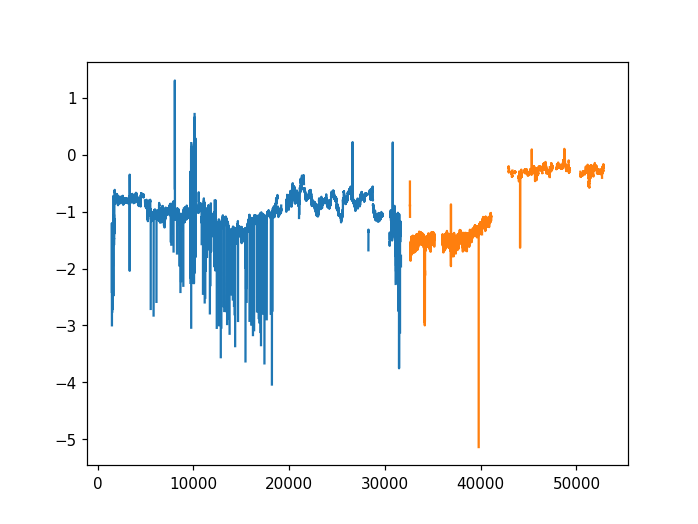

53280
53280


<IPython.core.display.Javascript object>


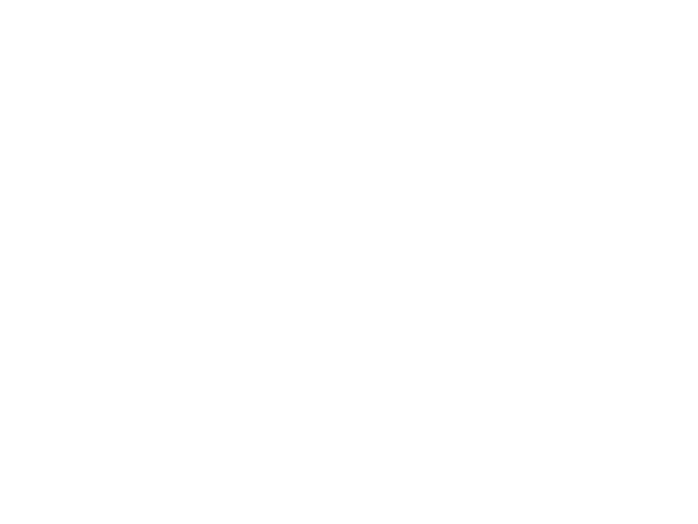

['ac9_N', 'ac9_ap', 'ac9_ap_u', 'ac9_bp', 'ac9_bp_u', 'ac9_chl', 'ac9_cp', 'ac9_cp_u', 'acs2_N', 'acs2_ap', 'acs2_ap_u', 'acs2_bp', 'acs2_bp_u', 'acs2_chl', 'acs2_cp', 'acs2_cp_u', 'acs_N', 'acs_ap', 'acs_ap_u', 'acs_bp', 'acs_bp_u', 'acs_chl', 'acs_cp', 'acs_cp_u', 'bb3_bb02', 'bb3_bb02_err', 'bb3_bbp', 'bb3_bbp_corr', 'bb3_bbp_err', 'cstar_cp', 'cstar_cp_err', 'flow', 'hplc_Allo', 'hplc_Alpha-beta-Car', 'hplc_Asta', 'hplc_But-fuco', 'hplc_Chl_a', 'hplc_Chl_c1', 'hplc_Chl_c2', 'hplc_Chlide_a', 'hplc_DP', 'hplc_DV_Chl_a', 'hplc_Diadino', 'hplc_Diato', 'hplc_Fuco', 'hplc_Hex-fuco', 'hplc_Lut', 'hplc_Neo', 'hplc_PML_only_Anth', 'hplc_PML_only_Chl_b_DVChl_b', 'hplc_PPC', 'hplc_PSC', 'hplc_PSP', 'hplc_Perid', 'hplc_Pras', 'hplc_TChl', 'hplc_Tacc', 'hplc_Tcar', 'hplc_Tot_Chl_a', 'hplc_Tot_Chl_b', 'hplc_Tot_Chl_c', 'hplc_Tpg', 'hplc_Viola', 'hplc_Zea', 'hplc_[chl_c3]', 'hplc_[ppc]/[tpig]', 'hplc_[psp]/[tpig]', 'hplc_[tacc]/[tchla]', 'hplc_[tchl_a]/[tpig]', 'hplc_beta-beta-Car', 'hplc_beta-ep

In [41]:
#plt.figure()   # cross-over bias for acs chl estimates

plt.plot(np.log10(acs['acs_chl']))
plt.plot(np.log10(acs['acs2_chl']))

print(len(acs['acs_chl']))
print(len(acs['acs2_chl']))

plt.figure()


print(sorted(list(acs.keys())))


In [42]:
# create acx_chl variable that merges the ac9_chl and acs_chl if available
#acs["acx_chl"] = (acs['time'], np.nanmean(np.asarray([acs['acs2_chl'].values, acs['acs_chl'].values]), axis=0) )
#acs["acx_chl"].attrs = {"acx_chl_units":"mg/m3",
 #                       "acx_chl_comment":"merged chl a from the two acs systems",
  #                     }

# plot it
#fig,ax = plt.subplots(2,1, figsize=[13,6])
#ax[0].semilogy(acs.time, acs.acx_chl, 'ro', lw=0.5, ms=5, mfc='none', alpha=0.05)
#ax[0].semilogy(acs.time, acs.acs_chl, '.', lw=0.5, ms=3, mfc='none', alpha=0.15)
#ax[0].semilogy(acs['uway_time'], acs.acs2_chl, 'k.', lw=0.5, ms=0.5, mfc='none', alpha=0.15)
#ax[0].set_ylim([0.001, 5])

#plt.figure()
#plt.plot(acs.time)
#plt.plot(acs2.time)
#ax[1].semilogy(np.arange(len(acs.time)), acs.acx_chl, 'ro', lw=0.5, ms=5, mfc='none', alpha=0.15)
#ax[1].semilogy(np.arange(len(acs.time)), acs.acs_chl, '.', lw=0.5, ms=8, mfc='none', alpha=0.15)
#plt.xlim(51700,52000)
#ax[1].semilogy(np.arange(len(acs.time)), acs.ac9_chl_adj, 'k.', lw=0.5, ms=1, mfc='none', alpha=0.15)

In [43]:
acs

<xarray.Dataset>
Dimensions:                                          (time: 53280, acs_wv: 176,
                                                      ac9_wv: 9, acs2_wv: 176,
                                                      bb3_wv: 3, hplc_time: 26)
Coordinates:
  * time                                             (time) datetime64[ns] 20...
  * acs_wv                                           (acs_wv) float64 400.0 ....
  * ac9_wv                                           (ac9_wv) float64 nan ......
  * acs2_wv                                          (acs2_wv) float64 400.0 ...
  * bb3_wv                                           (bb3_wv) float64 470.0 ....
  * hplc_time                                        (hplc_time) datetime64[ns] ...
Data variables: (12/106)
    flow                                             (time) float64 ...
    acs_chl                                          (time) float64 nan ... nan
    acs_ap                                           (time, acs_wv) float64 ...
    acs_ap_u                                         (time, acs_wv) float64 ...
    acs_bp                                           (time, acs_wv) float64 ...
    acs_bp_u                                         (time, acs_wv) float64 ...
    ...                                               ...
    hplc_[ppc]/[tpig]                                (hplc_time) float64 0.29...
    hplc_[psp]/[tpig]                                (hplc_time) float64 0.70...
    hplc_[tchl_a]/[tpig]                             (hplc_time) float64 0.40...
    hplc_Tcar                                        (hplc_time) float64 0.08...
    hplc_DP                                          (hplc_time) float64 0.08...
    hplc_file                                        <U24 'AMT_24_PigmentsDen...

0 1440 1750
1 8050 8100
2 9680 10250
3 31050 31200
4 31350 31700
5 31350 31700
6 34050 34200


<IPython.core.display.Javascript object>


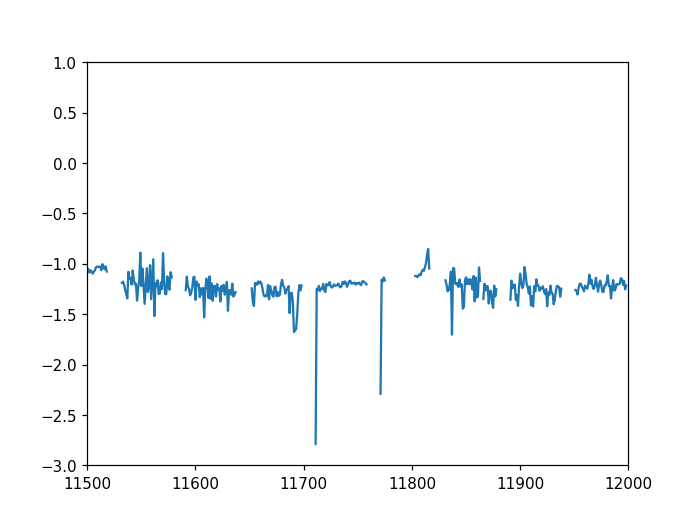

(11500.0, 12000.0)

In [44]:
### manually identify (using plot above) noisy parts of the acs_chl timeseries
i2rm = [ [1440,1750],
         [8050, 8100],
         [9680, 10250],
         [31050,31200],
         [31350,31700],
         [31350,31700],
         [34050,34200],
         #[39790,39795],
       
       ]
    


# set values to nan inside the above intervals
for istart,tmp in enumerate(i2rm):
    print(istart, tmp[0], tmp[1])
    acs['acs_chl'].values[tmp[0]:tmp[1]] = np.nan
    acs['acs_ap'].values[tmp[0]:tmp[1], :] = np.nan
    acs['acs_ap_u'].values[tmp[0]:tmp[1], :] = np.nan
    acs['acs_cp'].values[tmp[0]:tmp[1], :] = np.nan
    acs['acs_cp_u'].values[tmp[0]:tmp[1], :] = np.nan
    
    acs['acs2_chl'].values[tmp[0]:tmp[1]] = np.nan
    acs['acs2_ap'].values[tmp[0]:tmp[1], :] = np.nan
    acs['acs2_ap_u'].values[tmp[0]:tmp[1], :] = np.nan
    acs['acs2_cp'].values[tmp[0]:tmp[1], :] = np.nan
    acs['acs2_cp_u'].values[tmp[0]:tmp[1], :] = np.nan
    
    
#########
plt.figure()
plt.plot(np.log10(acs['acs_chl']))
plt.plot(np.log10(acs['acs2_chl']))
plt.ylim(-3,1)
plt.xlim(11500,12000)

[ 1728  1729  1730 ... 52917 52918 52919]
[    0     1     2 ... 53277 53278 53279]
[    0     1     2 ... 53277 53278 53279]


<IPython.core.display.Javascript object>


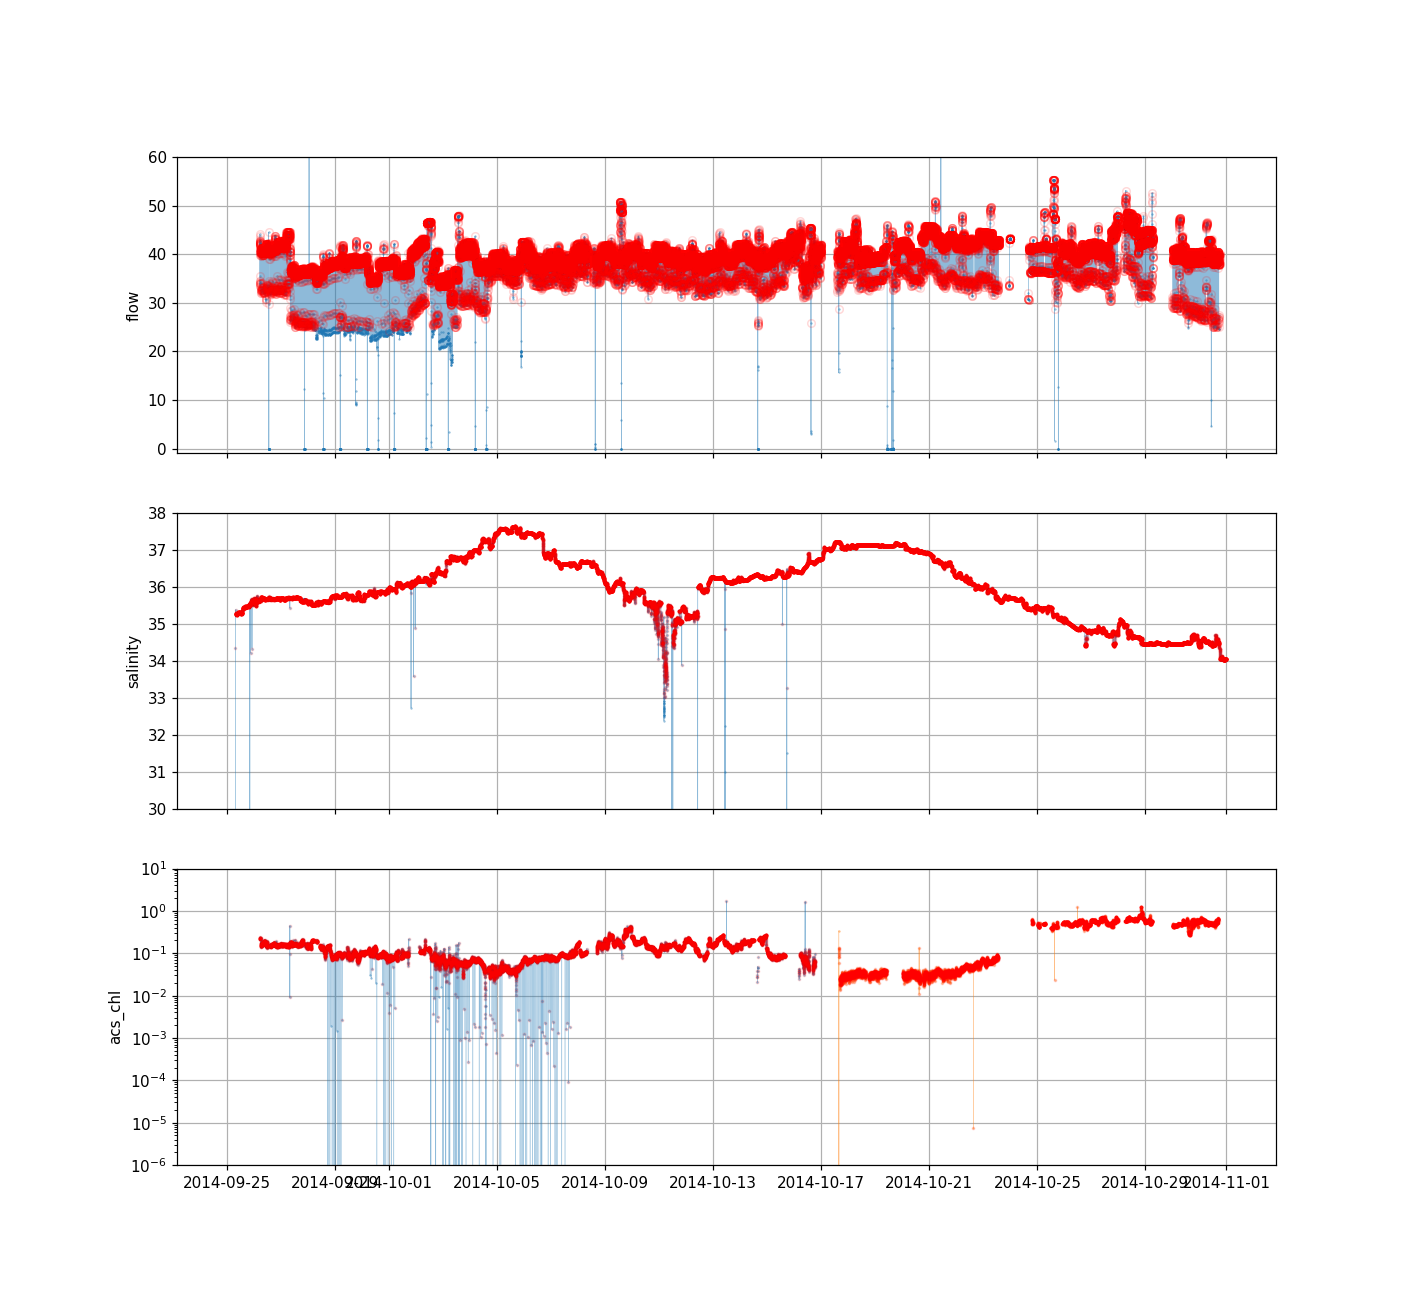

(1e-06, 10)

In [45]:
# filter acs data for MQ and noisy events
MIN_FLOW_RATE = 25
MIN_SAL = 33

i2f1 = np.where((acs.uway_sal>MIN_SAL) & (acs.flow>MIN_FLOW_RATE))[0]  
i2f2 = np.where((np.isnan(acs.uway_sal)==True) | (np.isnan(acs.flow)==True))[0]

i2f = np.union1d(i2f1, i2f2)

print(i2f1)
print(i2f2)
print(i2f)

fig, ax = plt.subplots(3,1, figsize=(13, 12), sharex=True)
ax[0].plot(acs.time, acs.flow, '.-', lw=0.5, ms=1, alpha=0.5)
ax[0].plot(acs.time[i2f], acs.flow[i2f], 'ro', lw=0.5, ms=5, mfc='none', alpha=0.15)
ax[0].set_ylabel('flow')
ax[0].grid('on')
ax[0].set_ylim([-1, 60])


ax[1].plot(acs.time, acs.uway_sal, '.-', lw=0.5, ms=1, alpha=0.5)
ax[1].plot(acs.time[i2f], acs.uway_sal[i2f], 'r.', lw=0.1, ms=3, mfc='none', alpha=0.15)
ax[1].set_ylabel('salinity')
ax[1].grid('on')
ax[1].set_ylim([30, 38])

ax[2].semilogy(acs.time, acs.acs_chl, '.-', lw=0.5, ms=1, alpha=0.5)
ax[2].semilogy(acs.time, acs.acs2_chl, '.-', lw=0.5, ms=1, alpha=0.5)
ax[2].semilogy(acs.time[i2f], acs.acs_chl[i2f], 'r.', lw=0.1, ms=3, mfc='none', alpha=0.15)
ax[2].semilogy(acs.time[i2f], acs.acs2_chl[i2f], 'r.', lw=0.1, ms=3, mfc='none', alpha=0.15)
ax[2].set_ylabel('acs_chl')
ax[2].grid('on')
plt.ylim([1e-6, 10])

#print(acs.keys())
#print(i2f)
#len(i2f)
#for i in range(len)
 #   print(istart, tmp[0], tmp[1])
  #  acs['acs_chl'].values[tmp[0]:tmp[1]] = np.nan
   # acs['acs_ap'].values[tmp[0]:tmp[1], :] = np.nan
   #acs['acs_ap_u'].values[tmp[0]:tmp[1], :] = np.nan
#for istart,tmp in enumerate(i2f):
 #   print(istart, tmp[0], tmp[1])
  #  acs['acs_chl'].values[tmp[0]:tmp[1]] = np.nan
   # acs['acs_ap'].values[tmp[0]:tmp[1], :] = np.nan
   # acs['acs_ap_u'].values[tmp[0]:tmp[1], :] = np.nan


In [46]:
df_hplc.keys()
#df_hplc_surf.keys()
#list(df_hplc['STATION'])
#f_UND = df_hplc_surfloc[(df_hplc_surf['CTD'] == "UND") & (df_hplc_surf['Bottle'] == "UND")]
#df_CTD = f_hplc_surf.loc[(df_hplc_surf['CTD'] != "UND") & (df_hplc_surf['Bottle'] != "UND")]

Index(['Label', 'Sample Collector', 'Cruise Name', 'CTD number',
       'Volume filtered (L)', 'Name of Water Body',
       'collected with positive pressure or vacuum', 'Depth (meters)',
       'Filter storage before analysis', 'Filter type', 'Filter diameter (mm)',
       'Tot_Chl_a', 'Tot_Chl_b', 'Tot_Chl_c', 'Alpha-beta-Car', 'Allo',
       'But-fuco', 'Diadino', 'Diato', 'Fuco', 'Hex-fuco', 'Perid', 'Zea',
       'Chl_a', 'DV_Chl_a', 'Chlide_a', 'PML_only_Chl_b_DVChl_b', 'Chl_c1',
       'Chl_c2', '[Chl c3]', 'beta-epi-Car', 'beta-beta-Car', 'Lut', 'Neo',
       'Viola', 'Pras', 'PML_only_Anth', 'Asta', 'blank intentionally', 'TChl',
       'PPC', 'PSC', 'PSP', 'Tacc', 'Tpg', '[TAcc]/[Tchla]', '[PPC]/[Tpig]',
       '[PSP]/[TPig]', '[TChl a]/[TPig]', 'Tcar', 'DP', 'time'],
      dtype='object')

<IPython.core.display.Javascript object>


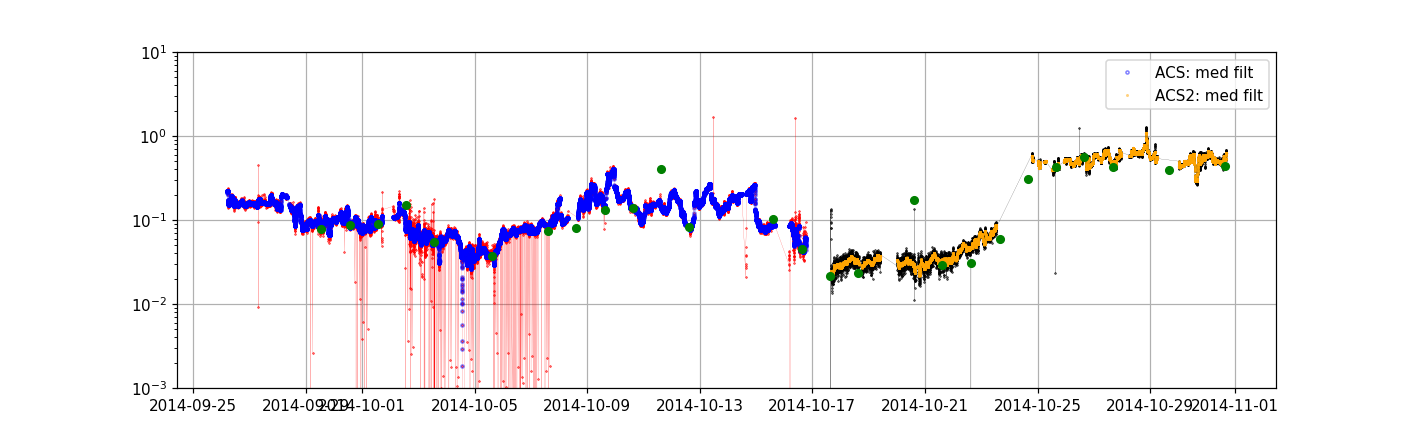

['flow', 'acs_chl', 'acs_ap', 'acs_ap_u', 'acs_bp', 'acs_bp_u', 'acs_cp', 'acs_cp_u', 'acs_N', 'acs2_chl', 'acs2_ap', 'acs2_ap_u', 'acs2_bp', 'acs2_bp_u', 'acs2_cp', 'acs2_cp_u', 'acs2_N', 'ac9_chl', 'ac9_ap', 'ac9_ap_u', 'ac9_bp', 'ac9_bp_u', 'ac9_cp', 'ac9_cp_u', 'ac9_N', 'bb3_bbp', 'bb3_bbp_err', 'bb3_bb02', 'bb3_bb02_err', 'bb3_bbp_corr', 'cstar_cp', 'cstar_cp_err', 'uway_lat', 'uway_lon', 'uway_air_temp1', 'uway_humidity1', 'uway_par', 'uway_tir1', 'uway_air_temp2', 'uway_humidity2', 'uway_par2', 'uway_tir2', 'uway_baro1', 'uway_baro2', 'uway_thermosalinograph_temp', 'uway_conductivity', 'uway_sal', 'uway_velocity', 'uway_chl', 'uway_sample_temp', 'uway_flowrate', 'uway_sst', 'uway_field28th', 'uway_field29th', 'hplc_label', 'hplc_sample_collector', 'hplc_cruise_name', 'hplc_ctd_number', 'hplc_volume_filtered_(l)', 'hplc_name_of_water_body', 'hplc_collected_with_positive_pressure_or_vacuum', 'hplc_depth', 'hplc_filter_storage_before_analysis', 'hplc_filter_type', 'hplc_filter_diam

/tmp/ipykernel_113392/2133434402.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax2.semilogy(acs.time[i2f][innan2], sg.medfilt(acs.acs2_chl[i2f][innan2], kernel_size=MEDFILT_WIN), 'bo',color='orange', lw=1, ms=1, mfc='none', alpha = 0.5, label='ACS2: med filt')


In [47]:
# median filter data
MEDFILT_WIN = 31

innan = np.where(~np.isnan(acs.acs_chl[i2f]))[0] # need to remove nans to prevent medfilt to be spiky near edges
innan2 = np.where(~np.isnan(acs.acs2_chl[i2f]))[0] # need to remove nans to prevent medfilt to be spiky near edges

fig2, ax2 = plt.subplots(1, figsize=(13, 4))
ax2.semilogy(acs.time[i2f][innan], acs.acs_chl[i2f][innan], 'r.-', lw=0.1, ms=1, mfc='none')
ax2.semilogy(acs.time[i2f][innan], sg.medfilt(acs.acs_chl[i2f][innan], kernel_size=MEDFILT_WIN), 'bo', lw=1, ms=2, mfc='none', alpha = 0.5, label='ACS: med filt')
ax2.semilogy(acs.time[i2f][innan2], acs.acs2_chl[i2f][innan2], 'k.-', lw=0.1, ms=1, mfc='none')
ax2.semilogy(acs.time[i2f][innan2], sg.medfilt(acs.acs2_chl[i2f][innan2], kernel_size=MEDFILT_WIN), 'bo',color='orange', lw=1, ms=1, mfc='none', alpha = 0.5, label='ACS2: med filt')
ax2.grid('on')
plt.legend()
plt.ylim([1e-3, 10])


print(list(acs.keys()))
ax2.semilogy(acs.hplc_time, acs.hplc_Tot_Chl_a, 'go', ms=5, alpha=1)#, mfc='none')
#a2.semilogy(df_CTD.index, df_CTD.Tot_Chl_a, 'ko', ms=7, alpha=1, mfc='none', zorder=60)
#ax2.scatter(df_CTD.index, df_CTD.Tot_Chl_a, c=df_CTD.Bottle.values, s=30, alpha=1, zorder=60, cmap = plt.get_cmap('inferno'), vmin=2, vmax=24)
#ax2.semilogy(df_UND.index, df_UND.Tot_Chl_a, 'ks', ms=7, alpha=0.85, mfc='c')

#########


<IPython.core.display.Javascript object>


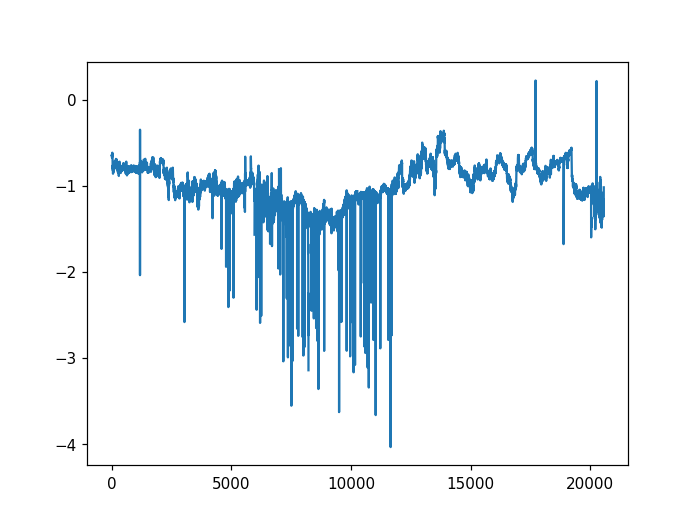

/local1/data/scratch/rsg/tjor/anaconda3/envs/monocle_test_hsp/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


<IPython.core.display.Javascript object>


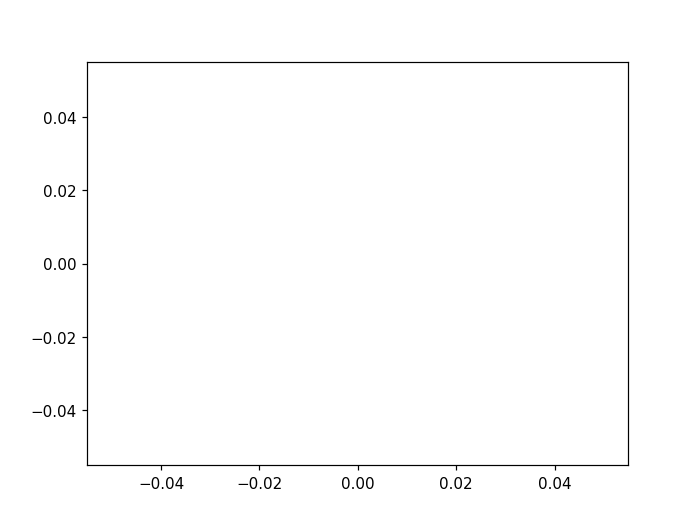

In [48]:
plt.figure()
plt.plot(np.log10(acs.acs_chl[i2f][innan]))

plt.figure()
plt.plot(np.log10(acs.acs2_chl[i2f][innan]))
# compare lat and lon of hplc and acs datasets
#fig, ax = plt.subplots(2, 1, figsize = (14, 8), sharex = True)

#ax[0].plot(acs.time, acs.uway_lat, '.', ms = 1, mfc = 'none')
##ax[0].plot(acs.hplc_time, acs.hplc_lat, 'ro', ms = 4, mfc = 'none', alpha = 0.5)
#ax[0].set_ylabel("latitude")
#ax[1].plot(acs.time, acs.uway_lon, '.', ms = 1, mfc = 'none')
#ax[1].plot(acs.hplc_time, acs.hplc_lon, 'ro', ms = 4, mfc = 'none', alpha = 0.5)
#ax[1].set_ylabel("longitude")

In [49]:
#####################################################################################
# creat lat-lon coordianets for hplc data - first need to interpolate to the u_way

ds_hplc_surf = pd.Series(df_hplc_surf.Tot_Chl_a.values, index = df_hplc_surf.index)
ds_hplc_surf = ds_hplc_surf.groupby('time').mean() # note - time field sometimes called date?

# averages duplicate values

df_lat = pd.Series(acs.uway_lat, index = acs.time.values)
df_lon = pd.Series(acs.uway_lon, index = acs.time.values)

df_hplc_coords = pd.DataFrame({'Tot_Chl_a': ds_hplc_surf, 'hplc_lat': df_lat, 'hplc_lon': df_lon })


df_hplc_coords = df_hplc_coords.interpolate().reindex(ds_hplc_surf.index)


_attrs = {}
_var = (['hplc_time'],df_hplc_coords['hplc_lat']) 
acs['hplc_lat'] = _var
acs['hplc_lat'].attrs = _attrs

_attrs = {}                                                                    
_var = (['hplc_time'],df_hplc_coords['hplc_lon']) 
acs['hplc_lon'] = _var
acs['hplc_lon'].attrs = _attrs

In [50]:
acs['hplc_lon']

<xarray.DataArray 'hplc_lon' (hplc_time: 26)>
array([-16.426825  , -20.21485   , -23.89176   , -25.910745  ,
       -27.08455   , -29.305245  , -29.140615  , -28.40486   ,
       -27.64715   , -26.921015  , -26.20462   , -25.486225  ,
       -25.04264   , -25.06529   , -25.08447   , -25.07113   ,
       -25.060175  , -25.035745  , -25.27556509, -26.63186   ,
       -27.874925  , -29.16742744, -32.103185  , -35.10188   ,
       -42.19838   , -50.340255  ])
Coordinates:
  * hplc_time  (hplc_time) datetime64[ns] 2014-09-29T13:15:00 ... 2014-10-31T...

In [51]:
# merge HPCL and ACS data
# see https://stackoverflow.com/questions/26517125/combine-two-pandas-dataframes-resample-on-one-time-column-interpolate
########################################################################################################################

# create pandas series with HPLC Tot_Chl_a data
ds_hplc_surf = pd.Series(df_hplc_surf.Tot_Chl_a.values, index = df_hplc_surf.index)


In [52]:
# df_CTD.keys()
# print(df_hplc_acs)
#df_hplc_combined['Tot_Chl_a'][0:14]= df_hplc_acs['Tot_Chl_a'][0:14]



In [53]:
# merge HPLC and ACS data
# see https://stackoverflow.com/questions/26517125/combine-two-pandas-dataframes-resample-on-one-time-column-interpolate
########################################################################################################################

# create pandas series with HPLC Tot_Chl_a data
ds_hplc_surf = pd.Series(df_hplc_surf.Tot_Chl_a.values, index = df_hplc_surf.index)

# averages duplicate values
ds_hplc_surf = ds_hplc_surf.groupby('time').mean() # note - time field sometimes called date?

df_acs = pd.Series(sg.medfilt(acs.acs_chl[i2f][innan], kernel_size=31), index = acs.time.values[i2f][innan])
df_hplc_acs = pd.DataFrame({'Tot_Chl_a': ds_hplc_surf, 'acs_chl': df_acs})
df_hplc_acs = df_hplc_acs.interpolate('index').reindex(ds_hplc_surf.index)
df_hplc_acs[14:] = np.nan


# create pandas series with medfilt ACS data: ACS2
df_acs2 = pd.Series(sg.medfilt(acs.acs2_chl[i2f][innan2], kernel_size=31), index = acs.time.values[i2f][innan2])
df_hplc_acs2 = pd.DataFrame({'Tot_Chl_a': ds_hplc_surf, 'acs2_chl': df_acs2})
df_hplc_acs2 = df_hplc_acs2.interpolate('index').reindex(ds_hplc_surf.index)
df_hplc_acs2.iloc[0:14] = np.nan

####################
a = np.array(df_hplc_acs['Tot_Chl_a'])[0:14]
b = np.array(df_hplc_acs2['Tot_Chl_a'])[14:25]
Tot_chl_combined = np.concatenate([a,b])

c = np.array(df_hplc_acs['acs_chl'])[0:14]
d = np.array(df_hplc_acs2['acs2_chl'])[14:25]
acs_combined = np.concatenate([c,d])


print(Tot_chl_combined)

[0.0774088  0.08648401 0.08879664 0.15109975 0.05487582 0.03694744
 0.07306386 0.08061778 0.13051133 0.13728442 0.40794024 0.08179769
 0.10392038 0.04563747 0.02172943 0.02368837 0.17284471 0.02935535
 0.03086217 0.05925237 0.31172515 0.42464357 0.56163845 0.43154328
 0.39712032]


In [54]:
#df_hplc_surf_new = df_hplc_surf
# merge HPCL and ACS data
# see https://stackoverflow.com/questions/26517125/combine-two-pandas-dataframes-resample-on-one-time-column-interpolate
# here made with dataframe instead of series

# averages duplicate values
#df_hplc_surf_new = df_hplc_surf_new.groupby('time').mean() 

# create pandas series with medfilt ACS data
#df_acs = pd.Series(sg.medfilt(acs.acs_chl[i2f][innan], kernel_size=31), index = acs.time.values[i2f][innan])
#df_hplc_acs = pd.DataFrame({'Tot_Chl_a': df_hplc_surf_new.Tot_Chl_a, 'acs_chl': df_acs})
#df_hplc_acs = df_hplc_acs.interpolate('index').reindex(df_hplc_surf_new.index)
    


In [55]:
# compute residuals and stats in LOG SPACE
rres = np.log10(df_hplc_acs.acs_chl.values) / np.log10(df_hplc_acs.Tot_Chl_a.values) - 1
delta = np.nanmedian(rres)
sigma = prcrng(rres)
N = sum(~np.isnan(rres))

print(delta, sigma, N)

# compute residuals and stats for ACS2
rres2 = np.log10(df_hplc_acs2.acs2_chl.values)/np.log10(df_hplc_acs2.Tot_Chl_a.values) - 1
delta2 = np.nanmedian(rres2)
sigma2 = prcrng(rres2)
N2 = sum(~np.isnan(rres2))
print(delta2, sigma2, N2)

# compute residuals and stats for ACSc combined
# compute residuals and stats for ACSc combined
rres3 = np.log10(acs_combined)/np.log10(Tot_chl_combined) - 1
delta3 = np.nanmedian(rres3)
sigma3 = prcrng(rres3)
N3 = N2 + N
print(delta3, sigma3, N3)


-0.01799204635930679 0.05696028811811347 14
-0.12465044136126413 0.12747115796651765 11
-0.029530547040304 0.0854845477117532 25


In [56]:
# compute residuals and stats in  LINEAR space
rres = df_hplc_acs.acs_chl.values/df_hplc_acs.Tot_Chl_a.values - 1
delta = np.nanmedian(rres)
sigma = prcrng(rres)
N = sum(~np.isnan(rres))
print(delta, sigma, N)

# compute residuals and stats for ACS2
rres2 = df_hplc_acs2.acs2_chl.values/df_hplc_acs2.Tot_Chl_a.values - 1
delta2 = np.nanmedian(rres2)
sigma2 = prcrng(rres2)
N2 = sum(~np.isnan(rres2))
print(delta2, sigma2, N2)


# compute residuals and stats for ACSc combined
rres3 = acs_combined/Tot_chl_combined - 1
delta3 = np.nanmedian(rres3)
sigma3 = prcrng(rres3)
N3 = N2 + N
print(delta3, sigma3, N3)

0.053951135055656185 0.13484591524423123 14
0.20977096899719738 0.2886547660486731 11
0.06547086568831317 0.21638673162241723 25


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy import signal as sg
from datetime import datetime as dt

<IPython.core.display.Javascript object>


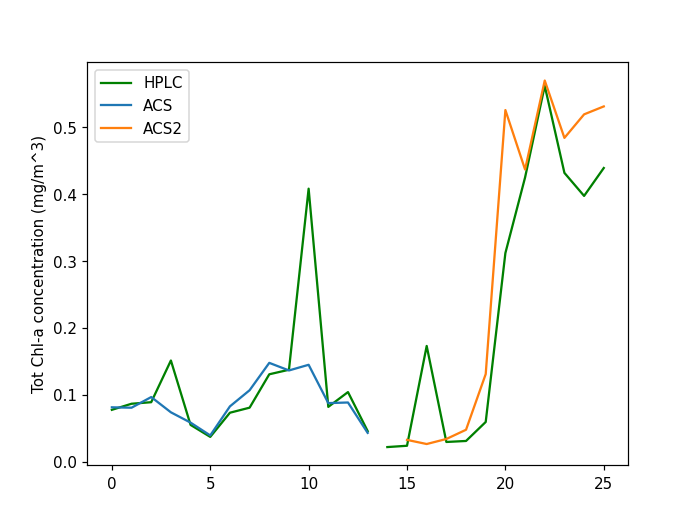

[0.0774088  0.08648401 0.08879664 0.15109975 0.05487582 0.03694744
 0.07306386 0.08061778 0.13051133 0.13728442 0.40794024 0.08179769
 0.10392038 0.04563747        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan]
[0.081144   0.08055513 0.09649282 0.07367748 0.05827564 0.03915133
 0.0825575  0.10666672 0.14758812 0.13624251 0.14470587 0.08744066
 0.08836256 0.04296322        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan]
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.03246269 0.02628458 0.03382438
 0.04761241 0.13082709 0.5254121  0.43659798 0.56956401 0.48384142
 0.51900351 0.53086409]


In [58]:
plt.figure()
plt.plot(df_hplc_acs.Tot_Chl_a.values,label='HPLC',color='green')
plt.plot(df_hplc_acs.acs_chl.values,label='ACS')
plt.plot(df_hplc_acs2.Tot_Chl_a.values,color='green')
plt.plot(df_hplc_acs2.acs2_chl.values,label='ACS2')
plt.ylabel('Tot Chl-a concentration (mg/m^3)')
#plt.xlabel('Sample index')
plt.legend()

print(df_hplc_acs.Tot_Chl_a.values)
print(df_hplc_acs.acs_chl.values)
print(df_hplc_acs2.acs2_chl.values)

<IPython.core.display.Javascript object>


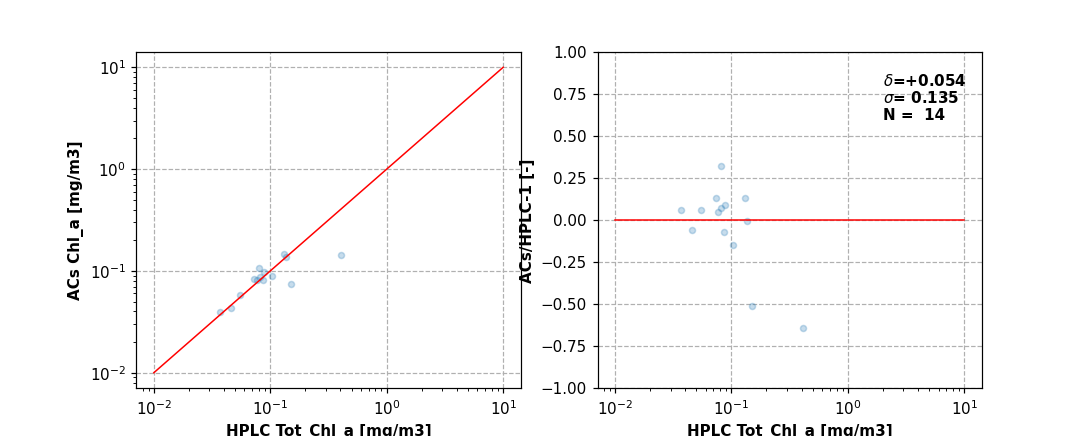

[0.0774088  0.08648401 0.08879664 0.15109975 0.05487582 0.03694744
 0.07306386 0.08061778 0.13051133 0.13728442 0.40794024 0.08179769
 0.10392038 0.04563747        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan]


In [59]:
fig, ax = plt.subplots(1,2, figsize=(10, 4))

ax[0].loglog(df_hplc_acs.Tot_Chl_a.values, df_hplc_acs.acs_chl.values, 'o', ms=4, alpha=0.25)
x = np.logspace(np.log10(0.01), np.log10(10), 100)
ax[0].loglog(x, x, 'r-', lw=1)
ax[0].grid('on', ls='--')
ax[0].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
ax[0].set_ylabel('ACs Chl_a [mg/m3]', fontweight='bold')

ax[1].semilogx(df_hplc_acs.Tot_Chl_a.values, rres, 'o', ms=4, alpha=0.25)
ax[1].semilogx(x, x*0, 'r-', lw=1)
ax[1].grid('on', ls='--')
ax[1].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
ax[1].set_ylabel('ACs/HPLC-1 [-]', fontweight='bold')
ax[1].set_ylim([-1, 1])
ax[1].text(2, 0.8, r'$\delta$='+f'{delta:+0.3}', fontweight='bold')
ax[1].text(2, 0.7, r'$\sigma$='+f'{sigma: 0.3}', fontweight='bold')
ax[1].text(2, 0.6, f'N = {N: 0}', fontweight='bold')


print(df_hplc_acs.Tot_Chl_a.values)

<IPython.core.display.Javascript object>


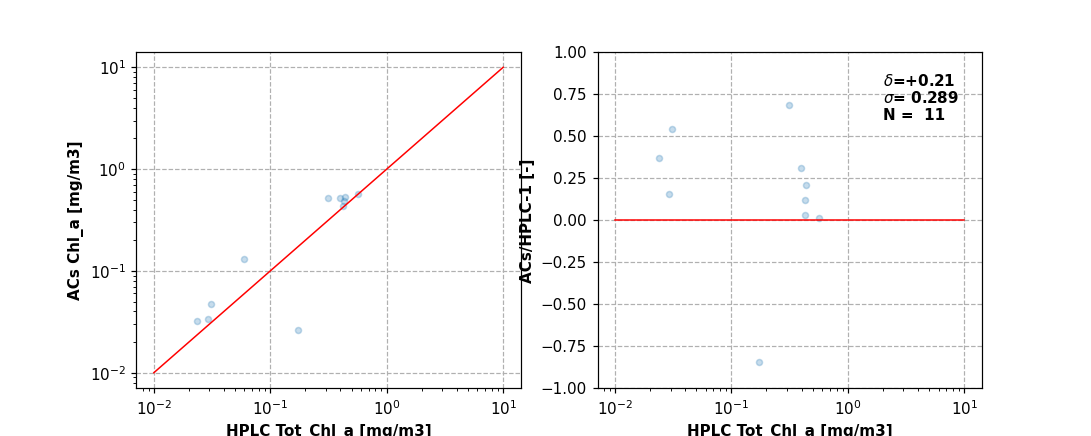

[0.0774088  0.08648401 0.08879664 0.15109975 0.05487582 0.03694744
 0.07306386 0.08061778 0.13051133 0.13728442 0.40794024 0.08179769
 0.10392038 0.04563747        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan]


In [60]:
fig, ax = plt.subplots(1,2, figsize=(10, 4))

ax[0].loglog(df_hplc_acs2.Tot_Chl_a.values, df_hplc_acs2.acs2_chl.values, 'o', ms=4, alpha=0.25)
x = np.logspace(np.log10(0.01), np.log10(10), 100)
ax[0].loglog(x, x, 'r-', lw=1)
ax[0].grid('on', ls='--')
ax[0].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
ax[0].set_ylabel('ACs Chl_a [mg/m3]', fontweight='bold')

ax[1].semilogx(df_hplc_acs2.Tot_Chl_a.values, rres2, 'o', ms=4, alpha=0.25)
ax[1].semilogx(x, x*0, 'r-', lw=1)
ax[1].grid('on', ls='--')
ax[1].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
ax[1].set_ylabel('ACs/HPLC-1 [-]', fontweight='bold')
ax[1].set_ylim([-1, 1])
ax[1].text(2, 0.8, r'$\delta$='+f'{delta2:+0.3}', fontweight='bold')
ax[1].text(2, 0.7, r'$\sigma$='+f'{sigma2: 0.3}', fontweight='bold')
ax[1].text(2, 0.6, f'N = {N2: 0}', fontweight='bold')


print(df_hplc_acs.Tot_Chl_a.values)

<IPython.core.display.Javascript object>


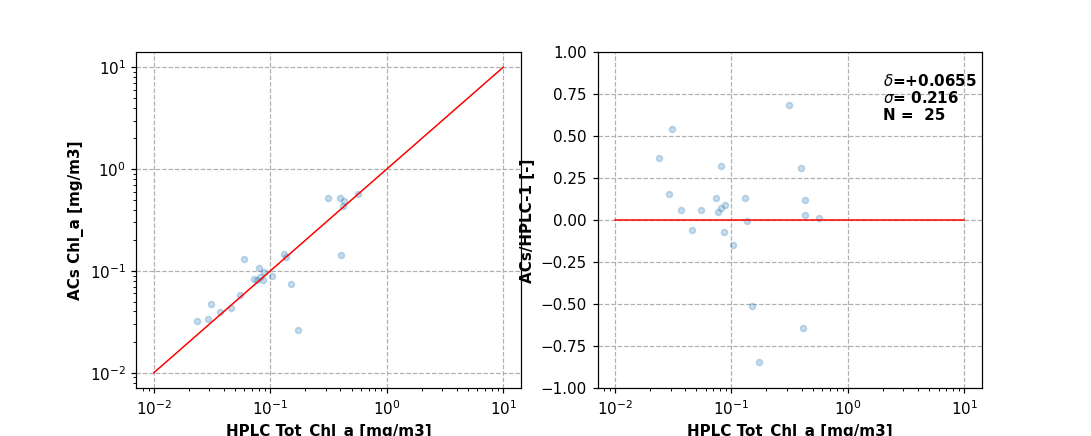

Text(2, 0.6, 'N =  25')

In [61]:
fig, ax = plt.subplots(1,2, figsize=(10, 4))

ax[0].loglog(Tot_chl_combined, acs_combined, 'o', ms=4, alpha=0.25)
x = np.logspace(np.log10(0.01), np.log10(10), 100)
ax[0].loglog(x, x, 'r-', lw=1)
ax[0].grid('on', ls='--')
ax[0].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
ax[0].set_ylabel('ACs Chl_a [mg/m3]', fontweight='bold')

ax[1].semilogx(Tot_chl_combined, rres3, 'o', ms=4, alpha=0.25)
ax[1].semilogx(x, x*0, 'r-', lw=1)
ax[1].grid('on', ls='--')
ax[1].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
ax[1].set_ylabel('ACs/HPLC-1 [-]', fontweight='bold')
ax[1].set_ylim([-1, 1])
ax[1].text(2, 0.8, r'$\delta$='+f'{delta3:+0.3}', fontweight='bold')
ax[1].text(2, 0.7, r'$\sigma$='+f'{sigma3: 0.3}', fontweight='bold')
ax[1].text(2, 0.6, f'N = {N3: 0}', fontweight='bold')



<IPython.core.display.Javascript object>


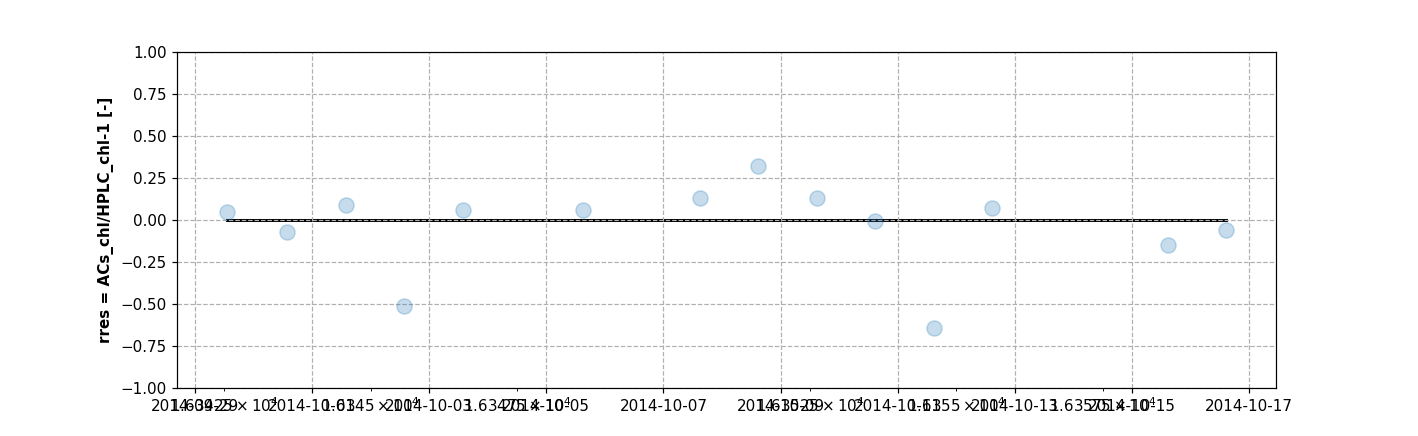

(-1.0, 1.0)

In [62]:
fig, ax = plt.subplots(1,1, figsize=(13, 4))
ax.semilogx(df_hplc_acs.index.values, rres, 'o', ms=10, alpha=0.25, zorder=60)
ax.plot(df_hplc_acs.index.values, rres*0, 'k-', lw=2, zorder=1)
ax.set_ylabel('rres = ACs_chl/HPLC_chl-1 [-]', fontweight='bold')
ax.grid('on', ls='--')
ax.set_ylim([-1, 1])

In [63]:
#ilrg_rres = np.where(abs(rres)>0.5)[0]
#print(rres[ilrg_rres])
#df_hplc_surf_new.iloc[ilrg_rres]

In [64]:
#df_hplc_surf_new.iloc[ilrg_rres].index.dayofyear
# tt.tm_yday

In [65]:
#df_hplc_surf_new.iloc[ilrg_rres].keys()

In [66]:
# find dates of large rres
r = df_hplc_acs.acs_chl / df_hplc_acs.Tot_Chl_a - 1
ii = np.where(abs(r)>0.4)[0]
print(r[ii])
# iss = 2
# [df_hplc_acs.Tot_Chl_a[ii][iss], df_hplc_acs.acx_chl[ii][iss]]

time
2014-10-02 13:42:00   -0.512392
2014-10-11 14:42:00   -0.645277
dtype: float64


In [67]:
# # de-bias ACS-chl following eq 3 in Graban et al., 2020 (https://doi.org/10.1364/OE.397863)
# df_hplc_acs.acs_chl_debiased = df_hplc_acs.acs_chl*(1-delta)

In [68]:
# # compute resuduals and stats
# rres = df_hplc_acs.acs_chl_debiased.values/df_hplc_acs.Tot_Chl_a.values-1

# delta = np.nanmedian(rres)
# sigma = prcrng(rres)
# N = len(rres)

# print(delta, sigma, N)

In [69]:
# fit data to power law -- not useD?
from scipy.optimize import curve_fit

def func(x, a, b):
    return a * x**b


popt, pcov = curve_fit(func, 0.014*acs_combined[~np.isnan(acs_combined)], Tot_chl_combined[~np.isnan(acs_combined)])


perr = np.sqrt(np.diag(pcov)) # parameter uncertainty 

print("chl_HPLC = a * chl_ACS^b " )

print("a = " + f'{popt[0]:.1f} ' + "+/- " + f'{perr[0]:.1f}' )
print("b = " + f'{popt[1]:.3f} ' + "+/- " + f'{perr[1]:.3f}' )


chl_HPLC = a * chl_ACS^b 
a = 21.6 +/- 12.5
b = 0.793 +/- 0.109


In [70]:
# fig, ax = plt.subplots(1,2, figsize=(10, 4))

# ax[0].loglog(df_hplc_acs.Tot_Chl_a.values, df_hplc_acs.acs_chl_debiased.values, 'o', ms=4, alpha=0.25)
# x = np.logspace(np.log10(0.01), np.log10(10), 100)
# ax[0].loglog(x, x, 'r-', lw=1)
# ax[0].grid('on', ls='--')
# ax[0].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
# ax[0].set_ylabel('ACS Chl_a [mg/m3]', fontweight='bold')

# ax[1].semilogx(df_hplc_acs.Tot_Chl_a.values, rres, 'o', ms=4, alpha=0.25)
# ax[1].semilogx(x, x*0, 'r-', lw=1)
# ax[1].grid('on', ls='--')
# ax[1].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
# ax[1].set_ylabel('ACS/HPLC-1 [-]', fontweight='bold')

# ax[1].text(2, 0.8, r'$\delta$='+f'{delta:+0.3}', fontweight='bold')
# ax[1].text(2, 0.7, r'$\sigma$='+f'{sigma: 0.3}', fontweight='bold')
# ax[1].text(2, 0.6, f'N = {N: 0}', fontweight='bold')



A = 25.118864315095795 +/- 4.285781202240117
B = 0.836 +/- 0.232
0.703


<IPython.core.display.Javascript object>


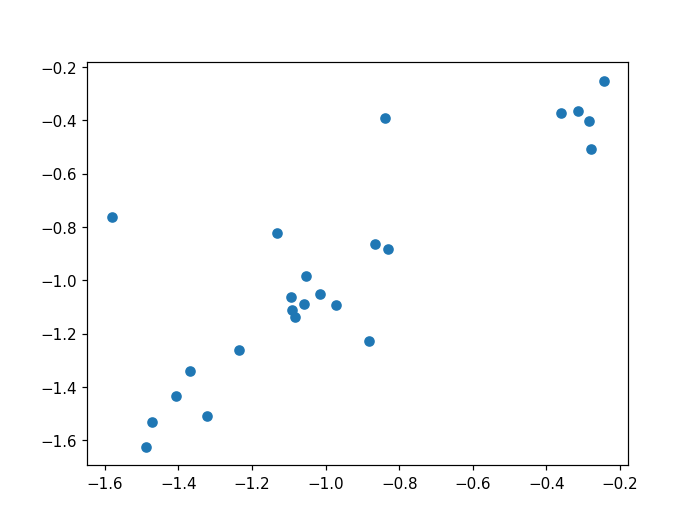

In [71]:
# as previous but apply log transform prior to fitting
import scipy

linear_mod = scipy.stats.linregress(np.log10(0.014*acs_combined[~np.isnan(acs_combined)]), np.log10(Tot_chl_combined[~np.isnan(acs_combined)]))

A = np.round(100*linear_mod.intercept)/100
B = np.round(1000*linear_mod.slope)/1000
r_sq = np.round(1000*linear_mod.rvalue**2)/100

r_sq = np.round(1000*linear_mod.rvalue**2)/1000
stderr = np.round(1000*linear_mod.stderr)/1000
interr = np.round(1000*linear_mod.intercept_stderr)/1000

print()

print('A = ' + str(10**A) + ' +/- ' + str(2*10**interr))
print('B = ' + str(B) + ' +/- ' + str(2*stderr))

print(r_sq)

plt.figure()
plt.scatter(np.log10(acs_combined[~np.isnan(acs_combined)]), np.log10(Tot_chl_combined[~np.isnan(acs_combined)]))

In [72]:
# de-bias ACS-chl following eq 3 in Graban et al., 2020 (https://doi.org/10.1364/OE.397863)
innan = np.where(~np.isnan(acs.acs_chl[i2f]))[0]
acs['acs_chl_debiased'] = acs.acs_chl*(1-delta3)# delta 3 is delta for combined AC-S
# acs['acs_chl_debiased'] = acs.acs_chl*(1-delta)
acs_out = pd.DataFrame(data = {'lat [degN]': acs.uway_lat[i2f][innan],
                               'lon [degE]': acs.uway_lon[i2f][innan],
                               'acs_chl_debiased [mg_m3]': acs.acs_chl_debiased[i2f][innan]
                              }  ,
                      index = acs.time.values[i2f][innan])


# de-bias ACS-2 
innan2 = np.where(~np.isnan(acs.acs2_chl[i2f]))[0]
acs['acs2_chl_debiased'] = acs.acs2_chl*(1-delta3) # delta 3 is delta for combined AC-S
acs2_out = pd.DataFrame(data = {'lat [degN]': acs.uway_lat[i2f][innan2],
                               'lon [degE]': acs.uway_lon[i2f][innan2],
                               'acs2_chl_debiased [mg_m3]': acs.acs2_chl_debiased[i2f][innan2]
                              }  )
                    #  index = acs.time.values[i2f][innan])
# acs_out.index.rename('date_time [UTC]', inplace = True)
acs_out.index.rename('date_time [UTC]', inplace = True)
acs2_out.index.rename('date_time [UTC]', inplace = True)

In [73]:
# add attributes to acs_chl_debiased
acs.acs_chl_debiased.attrs["debiasing_equation"] = "acs.acs_chl_debiased = acs.acs_chl*(1-delta)"
acs.acs_chl_debiased.attrs["delta"] = delta3
acs.acs_chl_debiased.attrs["sigma"] = sigma3
acs.acs_chl_debiased.attrs["units"] = "mg/m3"
acs.acs_chl_debiased.attrs["comments"] = "delta=np.nanmedian(rres), sigma=prcrng(rres), rres=acs_chl/HPLC_Tot_Chl_a-1, based on surface data"
acs.acs_chl_debiased.attrs["HPLC_Tot_chla"] = df_hplc_acs.Tot_Chl_a.values
acs.acs_chl_debiased.attrs["HPLC_Tot_chla_units"] = "mg/m3"
acs.acs_chl_debiased.attrs["acs_chl"] = df_hplc_acs.acs_chl.values
acs.acs_chl_debiased.attrs["acs_chl_units"] = "mg/m3"
acs.acs_chl_debiased.attrs["processed_on"] = dt.now().strftime("%Y-%m-%d %H:%M:%S.%f")
acs.acs_chl_debiased.attrs["match_up_dates"] = df_hplc_acs.index.format()


acs.acs2_chl_debiased.attrs["debiasing_equation"] = "acs.acs_chl_debiased = acs.acs_chl*(1-delta)"
acs.acs2_chl_debiased.attrs["delta"] = delta3
acs.acs2_chl_debiased.attrs["sigma"] = sigma3
acs.acs2_chl_debiased.attrs["units"] = "mg/m3"
acs.acs2_chl_debiased.attrs["comments"] = "delta=np.nanmedian(rres), sigma=prcrng(rres), rres=acs_chl/HPLC_Tot_Chl_a-1, based on surface data"
acs.acs2_chl_debiased.attrs["HPLC_Tot_chla"] = df_hplc_acs2.Tot_Chl_a.values
acs.acs2_chl_debiased.attrs["HPLC_Tot_chla_units"] = "mg/m3"
acs.acs2_chl_debiased.attrs["acs_chl"] = df_hplc_acs2.acs2_chl.values
acs.acs2_chl_debiased.attrs["acs_chl_units"] = "mg/m3"
acs.acs2_chl_debiased.attrs["processed_on"] = dt.now().strftime("%Y-%m-%d %H:%M:%S.%f")
acs.acs2_chl_debiased.attrs["match_up_dates"] = df_hplc_acs2.index.format()



In [74]:
#plt.figure()

#plt.plot(np.log10(acs['acs2_chl'].values))
#plt.xlim(39770,50000)


<IPython.core.display.Javascript object>


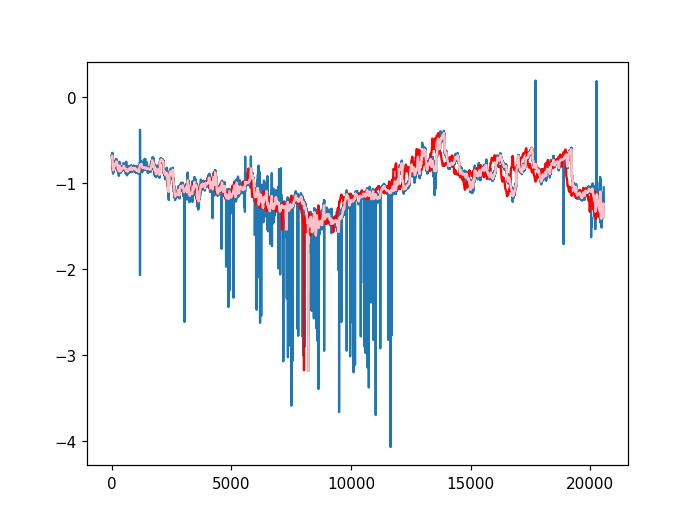

/tmp/ipykernel_113392/2255586404.py:3: RuntimeWarning: invalid value encountered in log10
  plt.plot(np.log10(acs['acs_chl_debiased'].values[i2f][innan]))
/tmp/ipykernel_113392/2255586404.py:8: RuntimeWarning: invalid value encountered in log10
  plt.plot(np.log10(acs_filtered_x['acs_chl_debiased'].values))
/tmp/ipykernel_113392/2255586404.py:22: RuntimeWarning: invalid value encountered in log10
  plt.plot(np.log10(acs_filtered_x['acs_chl_debiased'].values), color='pink')


In [75]:

#step x - # filters w.r.t. i2fn (mQ interval + previous manual spike removal) and innan
plt.figure()
plt.plot(np.log10(acs['acs_chl_debiased'].values[i2f][innan]))
ix = xr.DataArray(acs.time[i2f][innan], dims=['time']) 
acs_filtered_x = acs.sel(time = ix)
acs_filtered_x['acs_chl'].values = sg.medfilt(acs.acs_chl[i2f][innan], kernel_size=31) # apply med filter to acx chl and acx chl debiasesd 
acs_filtered_x['acs_chl_debiased'].values = sg.medfilt(acs.acs_chl_debiased[i2f][innan], kernel_size=31)
plt.plot(np.log10(acs_filtered_x['acs_chl_debiased'].values))

#step y - # filters w.r.t. ap (10the element) being > 0
i2kp = np.where((acs_filtered_x.acs_ap[:,10] > 0)) [0]
iy = xr.DataArray(acs_filtered_x.time[i2kp], dims=['time']) 
acs_filtered_xy = acs_filtered_x.sel(time = iy)

#step z - # filters w.r.t. acs chl being > 0
i2kp = np.where((acs_filtered_xy.acs_chl[:] > 0)) [0]
iz = xr.DataArray(acs_filtered_xy.time[i2kp], dims=['time']) 
acs_filtered_xyz = acs_filtered_xy.sel(time = iz)

#plt.figure()
plt.plot(np.log10(acs_filtered_xyz['acs_chl_debiased'].values),color='red')
plt.plot(np.log10(acs_filtered_x['acs_chl_debiased'].values), color='pink')
#plt.xlim(40,42)



<IPython.core.display.Javascript object>


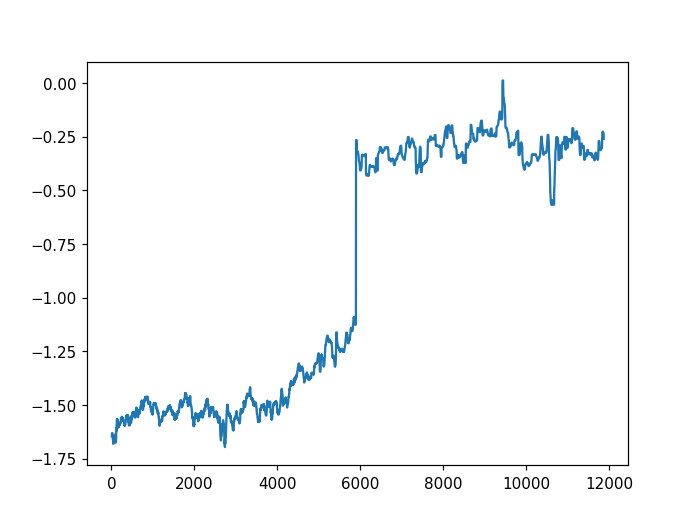

/tmp/ipykernel_113392/3006393327.py:8: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(acs2_filtered_x['acs2_chl_debiased'].values))


<IPython.core.display.Javascript object>


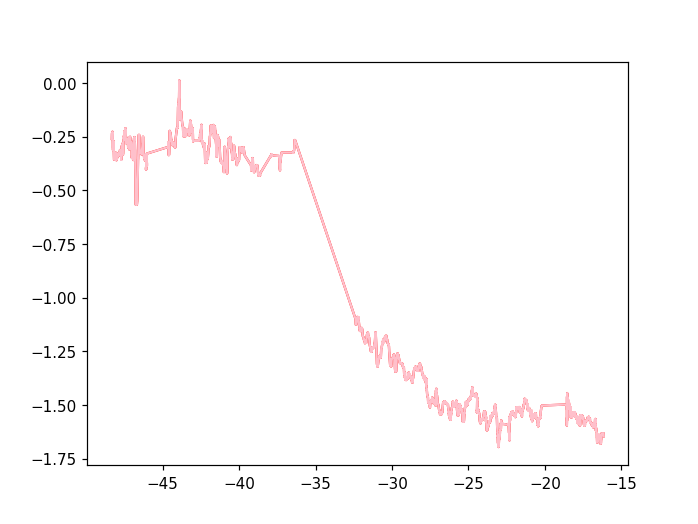

/tmp/ipykernel_113392/3006393327.py:22: RuntimeWarning: divide by zero encountered in log10
  plt.plot(acs2_filtered_x['uway_lat'], np.log10(acs2_filtered_x['acs2_chl_debiased'].values), color='pink')


In [76]:
# repeat for ACS 2
plt.figure()
#plt.plot(np.log10(acs['acs2_chl_debiased'].values[i2f][innan2]))
ix = xr.DataArray(acs.time[i2f][innan2], dims=['time']) 
acs2_filtered_x = acs.sel(time = ix)
acs2_filtered_x['acs2_chl'].values = sg.medfilt(acs.acs2_chl[i2f][innan2], kernel_size=31) # apply med filter to acx chl and acx chl debiasesd 
acs2_filtered_x['acs2_chl_debiased'].values = sg.medfilt(acs.acs2_chl_debiased[i2f][innan2], kernel_size=31)
plt.plot(np.log10(acs2_filtered_x['acs2_chl_debiased'].values))

# step y - # filters w.r.t. ap (10the element) being > 0
i2kp = np.where((acs2_filtered_x.acs2_ap[:,10] > 0))[0]
iy = xr.DataArray(acs2_filtered_x.time[i2kp], dims=['time']) 
acs2_filtered_xy = acs2_filtered_x.sel(time = iy)

# step z - # filters w.r.t. acs chl being > 0
i2kp = np.where((acs2_filtered_xy.acs2_chl[:] > 0)) [0]
iz = xr.DataArray(acs2_filtered_xy.time[i2kp], dims=['time']) 
acs2_filtered_xyz = acs2_filtered_xy.sel(time = iz)

plt.figure()
plt.plot(acs2_filtered_xyz['uway_lat'], np.log10(acs2_filtered_xyz['acs2_chl_debiased'].values),color='red')
plt.plot(acs2_filtered_x['uway_lat'], np.log10(acs2_filtered_x['acs2_chl_debiased'].values), color='pink')


In [77]:
#acs_filtered2 = acs_filtered
#acs_filtered2 = acs_filtered2.rename_vars({'time_': 'time'}, )

<IPython.core.display.Javascript object>


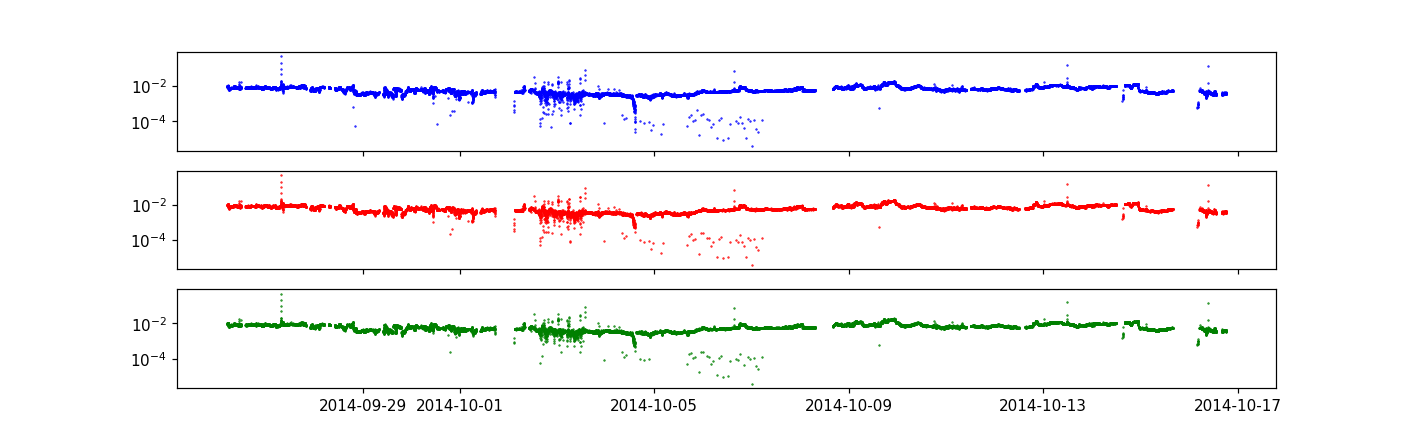

In [78]:
# plot to check                   
#iwv = np.where(acs_filtered.acs_wv==490)[0]
#fig, [ax, ax2] = plt.subplots(2,1, figsize=(13, 4), sharex=True)

#ax.semilogy(acs_filtered.time_[:], acs_filtered.acs_ap[:,iwv], 'b.', ms=1)
# ax.semilogy(acs_filtered.time_[:], sg.medfilt(x, 151), 'b.', ms=1)
#ax.semilogy(acs_filtered2.time, acs_filtered2.acs_ap[:,iwv], 'ro', ms=1, mfc='none', alpha=0.5)
#ax.grid('on')

#ax2.grid('on')

fig, [ax, ax2, ax3] = plt.subplots(3,1, figsize=(13, 4), sharex=True)

iwv = np.where(acs_filtered_x.acs_wv==490)[0]
ax.semilogy(acs.time[:], acs.acs_ap[:,iwv], 'b.', ms=1)

iwv_x = np.where(acs_filtered_x.acs_wv==490)[0]
ax2.semilogy(acs_filtered_x.time[:], acs_filtered_x.acs_ap[:,iwv_x], 'r.', ms=1)

iwv_y = np.where(acs_filtered_xy.acs_wv==490)[0]
ax3.semilogy(acs_filtered_xy.time[:], acs_filtered_xy.acs_ap[:,iwv_y], 'g.', ms=1)
#ax.semilogy(acs_filtered.time[:], sg.medfilt(x, 151), 'b.', ms=1)
#ax.semilogy(acs_filtered2.time, acs_filtered2.acs_ap[:,iwv], 'ro', ms=1, mfc='none', alpha=0.5)
#ax.grid('on')


In [79]:
# save to file for Silvia
# acs_out.to_csv('AMT29_ACS_chl_debiased.csv')
#acs_filtered2 = acs_filtered_xyz 

#print(len(acs_filtered_xyz['time']))
#print(len(acs2_filtered_xyz['time']))

key_string = acs_filtered_xyz.keys()
hplc_keys = [s for s in key_string if "hplc" in s]
other_keys = [s for s in key_string if "hplc" not in s]

#data_vars='all'

acs_filtered2  = xr.concat([acs_filtered_xyz, acs2_filtered_xyz],data_vars=other_keys,dim='time') # combines the 2 filtered x-rays back into net cdf (hplc keys are common)



In [80]:
#test for similar keys between AMT24 and AMT29 (baseline)

#load AMT29 (baseline for netcdf)
path_nc_29 = '/data/lazarev1/backup/cruise_data/AMT29/Public_Read_Only_Copy/DY110_Public/Optics_group/Processed/Underway/Step3/amt29_final_with_debiased_chl.nc'
nc_data_29 = xr.open_dataset(path_nc_29)  


#test for common and unqiue keys
keys_24 = list(acs_filtered2.keys())
keys_29 = list(nc_data_29.keys())
common_keys = set(keys_24).intersection(set(keys_29)) # keys contained in both cruises
extra_keys_24 =  set(keys_24) ^ common_keys # extra keys in AMT 28
extra_keys_29 = set(keys_29) ^ common_keys # extra keys in AMT29

print('common keys')
print(sorted(common_keys))

print('/n extra keys in amt24')
print(sorted(extra_keys_24))

# manual clean up of AMT 27 keys
# acs_filtered_xy = acs_filtered_xy.rename_vars({"uway_lon": "uway_long"})
# acs_filtered_xy = acs_filtered_xy.drop("ac9_N")
# acs_filtered_xy = acs_filtered_xy.drop("ac9_chl")

# manual clean up of AMT 26 keys
#acs_filtered2 = acs_filtered2.drop('ac9_N')
#acs_filtered2 = acs_filtered2.drop('ac9_ap')
#acs_filtered2 = acs_filtered2.drop('ac9_ap_u')
#acs_filtered2 = acs_filtered2.drop('ac9_bp')
#acs_filtered2 = acs_filtered2.drop('ac9_bp_u')
#acs_filtered2 = acs_filtered2.drop('ac9_chl')
#acs_filtered2 = acs_filtered2.drop('ac9_cp')
#acs_filtered2 = acs_filtered2.drop('ac9_cp_u')
#acs_filtered2 = acs_filtered2.drop('ac9_wv')


# clean-up extra pigments
acs_filtered2 = acs_filtered2.drop('hplc_[ppc]/[tpig]') # redumdant
acs_filtered2 = acs_filtered2.drop('hplc_[psp]/[tpig]') # redumdant
acs_filtered2 = acs_filtered2.drop('hplc_[tacc]/[tchla]') # redumdant
acs_filtered2 = acs_filtered2.drop('hplc_[tchl_a]/[tpig]') # redumdant
acs_filtered2 = acs_filtered2.drop('hplc_[chl_c3]') # redumdant



#print('/n extra keys in amt29')
#print(sorted(extra_keys_29))

#print('/n extra keys in amt26')
#print(sorted(extra_keys_26))
#sorted(acs_filtered2.keys())

common keys
['acs_N', 'acs_ap', 'acs_ap_u', 'acs_bp', 'acs_bp_u', 'acs_chl', 'acs_chl_debiased', 'acs_cp', 'acs_cp_u', 'bb3_bb02', 'bb3_bb02_err', 'bb3_bbp', 'bb3_bbp_corr', 'bb3_bbp_err', 'cstar_cp', 'cstar_cp_err', 'flow', 'hplc_Allo', 'hplc_Alpha-beta-Car', 'hplc_But-fuco', 'hplc_Chlide_a', 'hplc_DP', 'hplc_DV_Chl_a', 'hplc_Diadino', 'hplc_Diato', 'hplc_Fuco', 'hplc_Hex-fuco', 'hplc_Lut', 'hplc_Neo', 'hplc_PPC', 'hplc_PSC', 'hplc_PSP', 'hplc_Perid', 'hplc_Pras', 'hplc_Tacc', 'hplc_Tcar', 'hplc_Tot_Chl_a', 'hplc_Tot_Chl_b', 'hplc_Tot_Chl_c', 'hplc_Tpg', 'hplc_Viola', 'hplc_Zea', 'hplc_depth', 'hplc_filter_diameter', 'hplc_filter_type', 'hplc_lat', 'hplc_lon', 'uway_conductivity', 'uway_flowrate', 'uway_lat', 'uway_par2', 'uway_sal', 'uway_sst', 'uway_thermosalinograph_temp', 'uway_tir1', 'uway_tir2']
/n extra keys in amt24
['ac9_N', 'ac9_ap', 'ac9_ap_u', 'ac9_bp', 'ac9_bp_u', 'ac9_chl', 'ac9_cp', 'ac9_cp_u', 'acs2_N', 'acs2_ap', 'acs2_ap_u', 'acs2_bp', 'acs2_bp_u', 'acs2_chl', 'acs2_

In [81]:
print(sorted(acs_filtered2.keys()))
#acs_filtered2['hplc_bottle']))




['ac9_N', 'ac9_ap', 'ac9_ap_u', 'ac9_bp', 'ac9_bp_u', 'ac9_chl', 'ac9_cp', 'ac9_cp_u', 'acs2_N', 'acs2_ap', 'acs2_ap_u', 'acs2_bp', 'acs2_bp_u', 'acs2_chl', 'acs2_chl_debiased', 'acs2_cp', 'acs2_cp_u', 'acs_N', 'acs_ap', 'acs_ap_u', 'acs_bp', 'acs_bp_u', 'acs_chl', 'acs_chl_debiased', 'acs_cp', 'acs_cp_u', 'bb3_bb02', 'bb3_bb02_err', 'bb3_bbp', 'bb3_bbp_corr', 'bb3_bbp_err', 'cstar_cp', 'cstar_cp_err', 'flow', 'hplc_Allo', 'hplc_Alpha-beta-Car', 'hplc_Asta', 'hplc_But-fuco', 'hplc_Chl_a', 'hplc_Chl_c1', 'hplc_Chl_c2', 'hplc_Chlide_a', 'hplc_DP', 'hplc_DV_Chl_a', 'hplc_Diadino', 'hplc_Diato', 'hplc_Fuco', 'hplc_Hex-fuco', 'hplc_Lut', 'hplc_Neo', 'hplc_PML_only_Anth', 'hplc_PML_only_Chl_b_DVChl_b', 'hplc_PPC', 'hplc_PSC', 'hplc_PSP', 'hplc_Perid', 'hplc_Pras', 'hplc_TChl', 'hplc_Tacc', 'hplc_Tcar', 'hplc_Tot_Chl_a', 'hplc_Tot_Chl_b', 'hplc_Tot_Chl_c', 'hplc_Tpg', 'hplc_Viola', 'hplc_Zea', 'hplc_beta-beta-Car', 'hplc_beta-epi-Car', 'hplc_blank_intentionally', 'hplc_collected_with_positive

In [82]:
# save updated NetCDF file



acs_filtered2.to_netcdf(DIN_acs + fn_acs[:-3] + '_with_debiased_chl.nc')
acs_filtered2.close()


In [ ]:
print(acs_filtered2)

In [ ]:

# plot to show debiassing of chl
plt.figure(figsize=(24,10))
plt.rc('font', size=24)

plt.scatter(acs_filtered2['uway_lat'], acs_filtered2['acs_chl'], s=5,label='acs chl ')
plt.scatter(acs_filtered2['uway_lat'], acs_filtered2['acs_chl_debiased'], s=5,label='acs chl debiased')
plt.gca().set_yscale('log')
plt.legend()
plt.xlabel('Latitude')
plt.xlim(-50,50)
plt.ylabel('Chl [mg m$^{-3}$]')
    

In [ ]:
# plot to show acs and ac9 chl separately
plt.figure(figsize=(24,10))
plt.rc('font', size=24)

plt.scatter(acs_filtered2['uway_lat'], acs_filtered2['acs_chl'], s=5,label='acs chl ')
plt.scatter(acs_filtered2['uway_lat'], acs_filtered2['ac9_chl'], s=5,label='ac9 chl')
plt.gca().set_yscale('log')
plt.legend()
plt.xlabel('Latitude')
plt.xlim(-50,50)
plt.ylabel('Chl [mg m$^{-3}$]')

In [95]:
plt.i
plt.plot(acs_filtered2['acs_chl'])

plt.plot(acs_filtered2['ac9_chl'])

AttributeError: module 'matplotlib.pyplot' has no attribute 'i'

In [96]:
list(acs_filtered2.keys())

['flow',
 'acs_chl',
 'acs_ap',
 'acs_ap_u',
 'acs_bp',
 'acs_bp_u',
 'acs_cp',
 'acs_cp_u',
 'acs_N',
 'acs2_chl',
 'acs2_ap',
 'acs2_ap_u',
 'acs2_bp',
 'acs2_bp_u',
 'acs2_cp',
 'acs2_cp_u',
 'acs2_N',
 'bb3_bbp',
 'bb3_bbp_err',
 'bb3_bb02',
 'bb3_bb02_err',
 'bb3_bbp_corr',
 'cstar_cp',
 'cstar_cp_err',
 'uway_lat',
 'uway_lon',
 'uway_air_temp1',
 'uway_humidity1',
 'uway_par',
 'uway_tir1',
 'uway_air_temp2',
 'uway_humidity2',
 'uway_par2',
 'uway_tir2',
 'uway_baro1',
 'uway_baro2',
 'uway_thermosalinograph_temp',
 'uway_conductivity',
 'uway_sal',
 'uway_velocity',
 'uway_chl',
 'uway_sample_temp',
 'uway_flowrate',
 'uway_sst',
 'uway_field28th',
 'uway_field29th',
 'hplc_label',
 'hplc_sample_collector',
 'hplc_cruise_name',
 'hplc_volume_filtered_(l)',
 'hplc_name_of_water_body',
 'hplc_depth',
 'hplc_filter_storage_before_analysis',
 'hplc_filter_type',
 'hplc_filter_diameter',
 'hplc_Tot_Chl_a',
 'hplc_Tot_Chl_b',
 'hplc_Tot_Chl_c',
 'hplc_Alpha-beta-Car',
 'hplc_Allo',
